In [229]:
import pandas as pd
import numpy as np
import prophet
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator , DateFormatter
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from prophet import Prophet

%matplotlib inline

In [230]:
data = pd.read_csv("combined_data_1.csv", date_parser=["Date"])
data["Date"] = pd.to_datetime(data['Date'], format='mixed')
#data["new_date"] = data["Date"].dt.strftime('%Y-%m-%d %H:%M:%S')
data.head()

C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\1286839990.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv("combined_data_1.csv", date_parser=["Date"])


,Date,Hour,Ontario Demand
0,2005-01-01,1,15016
1,2005-01-01,2,14470
2,2005-01-01,3,14015
3,2005-01-01,4,13622
4,2005-01-01,5,13545


In [231]:
def update_hour_from_next_column(data):
    
    # Check if 'next_hour' is between 0 and 23, and update 'hour' in 'date_column'
    data['new_date_column'] = data.apply(lambda row: row['Date'].replace(hour=row['Hour'])
                                 if 0 <= row['Hour'] <= 23 else row['Date'], axis=1)

    # Drop the individual columns used to create 'date_column'
    #df.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'second', 'next_hour'], inplace=True)

    return data

# Example usage:
# Assuming you have a DataFrame called 'df' with columns: 'year', 'month', 'day', 'hour', 'minute', 'second', and 'next_column_name'
# Replace 'df' with your actual DataFrame name and 'next_column_name' with the appropriate column name.

df = update_hour_from_next_column(data)
#print(df)


In [232]:
"""def make_column_first(df, date_column):
    # Ensure the column exists in the DataFrame
    if "date_column" not in df.columns:
        print(f"Column '{date_column}' does not exist in the DataFrame.")
        return df

    # Move the specified column to the first position
    cols = df.columns.tolist()
    cols.remove(date_column)
    cols = [date_column] + cols

    # Reorder the columns in the DataFrame
    df = df[cols]

    return df

# Example usage:
# Assuming you have a DataFrame called 'df' and you want to make 'column_to_move' the first column.
# Replace 'df' with your actual DataFrame name and 'column_to_move' with the appropriate column name.

df = make_column_first(df, 'date_column')
print(df)
"""

'def make_column_first(df, date_column):\n    # Ensure the column exists in the DataFrame\n    if "date_column" not in df.columns:\n        print(f"Column \'{date_column}\' does not exist in the DataFrame.")\n        return df\n\n    # Move the specified column to the first position\n    cols = df.columns.tolist()\n    cols.remove(date_column)\n    cols = [date_column] + cols\n\n    # Reorder the columns in the DataFrame\n    df = df[cols]\n\n    return df\n\n# Example usage:\n# Assuming you have a DataFrame called \'df\' and you want to make \'column_to_move\' the first column.\n# Replace \'df\' with your actual DataFrame name and \'column_to_move\' with the appropriate column name.\n\ndf = make_column_first(df, \'date_column\')\nprint(df)\n'

In [233]:

# Get the column order
cols = df.columns.tolist()

# Check if the DataFrame has at least 3 columns
if len(cols) >= 4:
    # Move the third column to the first position
    new_cols = [cols[3]] + cols[:3] + cols[4:]

    # Reorder the columns in the DataFrame
    df = df[new_cols]
else:
    print("The DataFrame must have at least 3 columns to rearrange.")

# Example usage:
# Replace 'df' with your actual DataFrame name.

df


,new_date_column,Date,Hour,Ontario Demand
0,2005-01-01 01:00:00,2005-01-01,1,15016
1,2005-01-01 02:00:00,2005-01-01,2,14470
2,2005-01-01 03:00:00,2005-01-01,3,14015
3,2005-01-01 04:00:00,2005-01-01,4,13622
4,2005-01-01 05:00:00,2005-01-01,5,13545
...,...,...,...,...
149011,2021-12-31 20:00:00,2021-12-31,20,16046
149012,2021-12-31 21:00:00,2021-12-31,21,15529
149013,2021-12-31 22:00:00,2021-12-31,22,15112
149014,2021-12-31 23:00:00,2021-12-31,23,14596


### Seasonal Correction of Demand Data

In [234]:
df = df.drop(columns={"Date"}, axis = 1)

In [235]:
df = df.rename(columns={"new_date_column":"Date"})

In [236]:
df.dtypes

Date              datetime64[ns]
Hour                       int64
Ontario Demand             int64
dtype: object

In [237]:
data = df

In [238]:
df = df.rename(columns={"Date":"ds", "Ontario Demand":"y"})

In [239]:
data = df

In [240]:

"""# assuming df is your DataFrame, 'ds' is your date column and 'demand' is your demand column
#df_try['ds'] = pd.to_datetime(df['ds'])

# extract the year from the date
data['year'] = data['ds'].dt.year

# calculate the yearly average demand
data['yearly_average_demand'] = data.groupby('year')['y'].transform('mean')


data['day'] = data['ds'].dt.date
# calculate the daily average demand
#df_try['daily_average_demand'] = df_try.groupby('day')['y'].transform('mean')

# Normalize by dividing by 24
#df_try['daily_average_demand_normalized'] = df_try['daily_average_demand'] / 24
data['daily_average_demand'] = data.groupby('day')['y'].transform('mean') 

# Normalize by dividing by the length of values in that year
#f_try['yearly_average_demand_normalized'] = df_try['yearly_average_demand'] / df_try.groupby('year')['demand'].transform('count')


data["Daily_demand_trend_corrected"] = data["daily_average_demand"] - data["yearly_average_demand"]
data["hourly_demand_trend_and_season_corrected"] = data["y"] - data["Daily_demand_trend_corrected"]- data["yearly_average_demand"]
"""

'# assuming df is your DataFrame, \'ds\' is your date column and \'demand\' is your demand column\n#df_try[\'ds\'] = pd.to_datetime(df[\'ds\'])\n\n# extract the year from the date\ndata[\'year\'] = data[\'ds\'].dt.year\n\n# calculate the yearly average demand\ndata[\'yearly_average_demand\'] = data.groupby(\'year\')[\'y\'].transform(\'mean\')\n\n\ndata[\'day\'] = data[\'ds\'].dt.date\n# calculate the daily average demand\n#df_try[\'daily_average_demand\'] = df_try.groupby(\'day\')[\'y\'].transform(\'mean\')\n\n# Normalize by dividing by 24\n#df_try[\'daily_average_demand_normalized\'] = df_try[\'daily_average_demand\'] / 24\ndata[\'daily_average_demand\'] = data.groupby(\'day\')[\'y\'].transform(\'mean\') \n\n# Normalize by dividing by the length of values in that year\n#f_try[\'yearly_average_demand_normalized\'] = df_try[\'yearly_average_demand\'] / df_try.groupby(\'year\')[\'demand\'].transform(\'count\')\n\n\ndata["Daily_demand_trend_corrected"] = data["daily_average_demand"] - dat

In [241]:
data = data.set_index(pd.DatetimeIndex(data['ds']))

### Building Short term model 

In [242]:
def shortterm_lm_model(short_term_data ):    
    columns_original_df = short_term_data.shape[1]
    short_term_data.iloc[:, (columns_original_df):(columns_original_df+24)] = 0
    for i in range(24):
        short_term_data[f"Hour{i}"] = 0
        short_term_data.loc[short_term_data["Hour"] == i, f"Hour{i}"] = 1

    #country = "Ontario"
    #short_term_data["country"] = "Ontario"

    #short_term_data.insert(0, "country", country)
 
    #country = short_term_data["country"].unique()

    short_term_data["wday"] = short_term_data["ds"].dt.day_name()
    wday = short_term_data['wday'].unique().astype(str).tolist()

    for i in wday:
        short_term_data[f"{i}"] = 0
        short_term_data.loc[short_term_data["wday"] == i, f"{i}"] = 1

    return short_term_data

In [243]:
df =  shortterm_lm_model(data)

<Axes: xlabel='ds'>

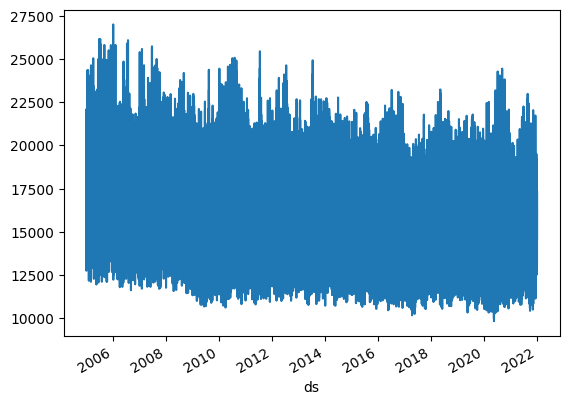

In [244]:
df['y'].plot()

In [245]:
df = df.drop('Hour', axis=1)

In [246]:
#df = df.rename(columns={"Date":"ds","Ontario Demand":"y"})

In [247]:
df = pd.DataFrame(df)
df.dtypes

ds           datetime64[ns]
y                     int64
Hour0                 int64
Hour1                 int64
Hour2                 int64
Hour3                 int64
Hour4                 int64
Hour5                 int64
Hour6                 int64
Hour7                 int64
Hour8                 int64
Hour9                 int64
Hour10                int64
Hour11                int64
Hour12                int64
Hour13                int64
Hour14                int64
Hour15                int64
Hour16                int64
Hour17                int64
Hour18                int64
Hour19                int64
Hour20                int64
Hour21                int64
Hour22                int64
Hour23                int64
wday                 object
Saturday              int64
Tuesday               int64
Friday                int64
Sunday                int64
Wednesday             int64
Monday                int64
Thursday              int64
dtype: object

In [248]:
#df['ds'] = pd.DatetimeIndex(df['ds'])

In [249]:
df = df.drop('wday', axis=1)

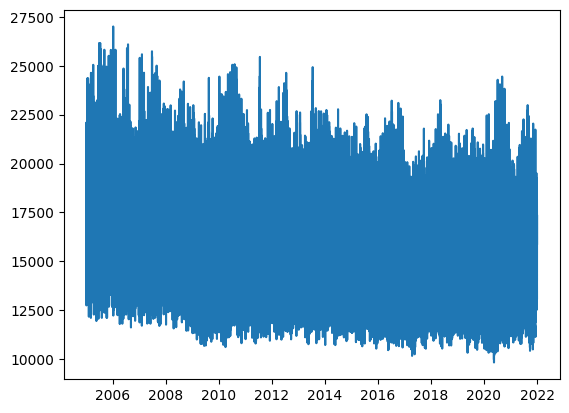

In [250]:
plt.plot(df["ds"],df["y"])

In [251]:
df.reset_index(drop=True, inplace=True)

In [252]:

# Sort the DataFrame by the 'date' column in ascending order
df.sort_values('ds', inplace=True)

# Split the DataFrame into train and test sets
train_start_date = '2005-01-01'
train_end_date = '2019-12-31'
test_start_date = '2020-01-01'

train_set = df[(df['ds'] >= train_start_date) & (df['ds'] <= train_end_date)]
test_set = df[df['ds'] >= test_start_date]

# If you want to reset the index of the new DataFrames
#train_set.reset_index(drop=True, inplace=True)
#test_set.reset_index(drop=True, inplace=True)

In [253]:
print(train_set,test_set)

                        ds      y  Hour0  Hour1  Hour2  Hour3  Hour4  Hour5  \
23     2005-01-01 00:00:00  15973      0      0      0      0      0      0   
0      2005-01-01 01:00:00  15016      0      1      0      0      0      0   
1      2005-01-01 02:00:00  14470      0      0      1      0      0      0   
2      2005-01-01 03:00:00  14015      0      0      0      1      0      0   
3      2005-01-01 04:00:00  13622      0      0      0      0      1      0   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
131443 2019-12-30 20:00:00  16510      0      0      0      0      0      0   
131444 2019-12-30 21:00:00  16154      0      0      0      0      0      0   
131445 2019-12-30 22:00:00  15606      0      0      0      0      0      0   
131446 2019-12-30 23:00:00  14849      0      0      0      0      0      0   
131471 2019-12-31 00:00:00  13578      0      0      0      0      0      0   

        Hour6  Hour7  ...  Hour21  Hour22  Hour23  

In [254]:
print(len(train_set), len(test_set))

131449 17544


In [255]:
# Slicing dataframe for Prophet model by using hourly demand trend and seasonal corrected

df_stm = df[["ds","y"]]


In [256]:
#df_stm = df_stm.rename(columns={"hourly_demand_trend_and_season_corrected":"y"})
##df_stm = df_stm.drop(columns="ds",axis=1)
#df_stm = df_stm.rename(columns={"Date":"ds"})

In [257]:
# Getting the location of teh first regressor

column_name = 'Hour0'

if column_name in df.columns:
    index_of_column = df.columns.get_loc(column_name)
    print(f"The index of '{column_name}' is: {index_of_column}")
else:
    print(f"Column '{column_name}' not found in the DataFrame.")

The index of 'Hour0' is: 2


In [258]:
# Slicing the dataframe to get all regressors
stm_variables = df.iloc[:,3:-7]

In [259]:
new_stm_df = pd.concat([df_stm, stm_variables],axis=1)

#### New training and test set for new dataframe

In [260]:
# Sort the DataFrame by the 'date' column in ascending order
new_stm_df.sort_values('ds', inplace=True)

# Split the DataFrame into train and test sets
train_start_date = '2005-01-01'
train_end_date = '2019-12-31'
test_start_date = '2020-01-01'

train_set = new_stm_df[(new_stm_df['ds'] >= train_start_date) & (new_stm_df['ds'] <= train_end_date)]
test_set = new_stm_df[new_stm_df['ds'] >= test_start_date]

# If you want to reset the index of the new DataFrames
#train_set.reset_index(drop=True, inplace=True)
#test_set.reset_index(drop=True, inplace=True)""

In [261]:
model = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True)

In [262]:
# Add regressor

for i in stm_variables.columns:
    model.add_regressor(i)
model.add_country_holidays("CA")

In [263]:
model.fit(train_set)

17:53:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1] done processing


In [264]:
model.params

OrderedDict([('lp__', array([[310054.]])),
             ('k', array([[0.0715824]])),
             ('m', array([[0.660238]])),
             ('delta',
              array([[-4.08698e-01, -1.47987e-06, -1.47050e-02,  7.81900e-01,
                      -6.95414e-01,  7.19512e-03,  2.00117e-02, -1.00849e+00,
                       1.38205e+00,  4.20124e-01, -6.13489e-01,  1.98716e-02,
                      -1.29932e-01,  8.47300e-02,  2.09081e-01, -2.54729e-01,
                       1.47873e-01,  5.39700e-01, -1.65241e+00,  1.53076e+00,
                      -7.96492e-01, -1.78540e-01,  1.37089e+00, -1.63197e+00,
                       8.81412e-01]])),
             ('sigma_obs', array([[0.057206]])),
             ('beta',
              array([[-1.48500e-03,  9.25748e-03,  2.10680e-02,  1.96422e-02,
                      -5.66586e-03, -4.79380e-03,  7.22785e-05, -2.80272e-03,
                       1.44028e-03, -3.58234e-03,  1.24158e-03, -4.01307e-03,
                      -1.45545e-04, -2

In [265]:
#24*731
future = model.make_future_dataframe(freq="H",periods=17567)
future

,ds
0,2005-01-01 00:00:00
1,2005-01-01 01:00:00
2,2005-01-01 02:00:00
3,2005-01-01 03:00:00
4,2005-01-01 04:00:00
...,...
149011,2021-12-31 19:00:00
149012,2021-12-31 20:00:00
149013,2021-12-31 21:00:00
149014,2021-12-31 22:00:00


In [266]:
future = pd.merge(future, new_stm_df , on="ds", how = "inner")

In [267]:
forecast = model.predict(future)
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
149011,2021-12-31 19:00:00,17686.978837,10466.229852,24609.369751
149012,2021-12-31 20:00:00,17570.019784,10024.038995,24635.469216
149013,2021-12-31 21:00:00,17201.662750,9969.441572,24253.282895
149014,2021-12-31 22:00:00,16283.526682,8836.129317,23088.059034
149015,2021-12-31 23:00:00,15071.386296,7660.268179,22212.986480


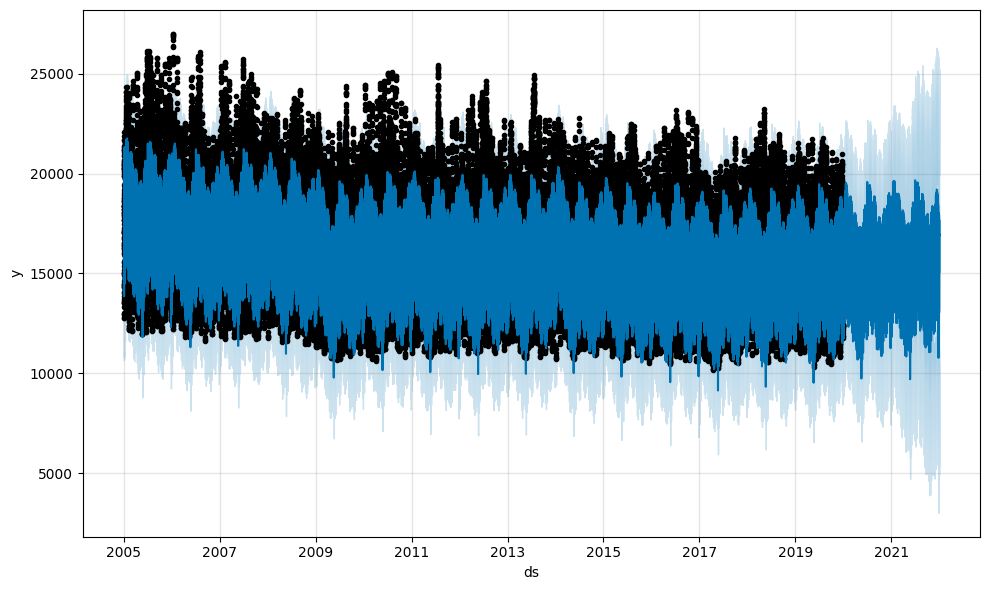

In [268]:
model.plot(forecast);

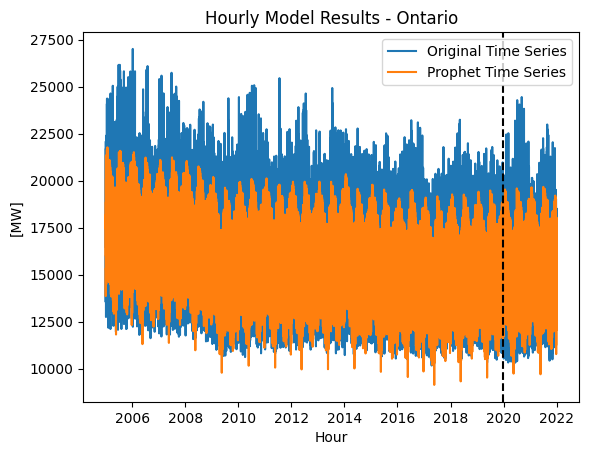

In [269]:
plt.plot(new_stm_df["ds"], new_stm_df["y"], label='Original Time Series')

# Plotting the second time series
plt.plot(forecast["ds"], forecast["yhat"], label='Prophet Time Series')

# Set the labels and title for the plot
plt.xlabel('Hour')
plt.ylabel('[MW]')
plt.title('Hourly Model Results - Ontario')
plt.axvline(x=train_set["ds"].iloc[-1], linestyle="--", color="black")
ax = plt.gca()
#date_format = mdates.DateFormatter('%Y-%m-%d %H:%M')
#ax.xaxis.set_major_formatter(date_format)
#plt.gcf().autofmt_xdate()

# Display the legend
plt.legend()

# Display the plot
plt.show()

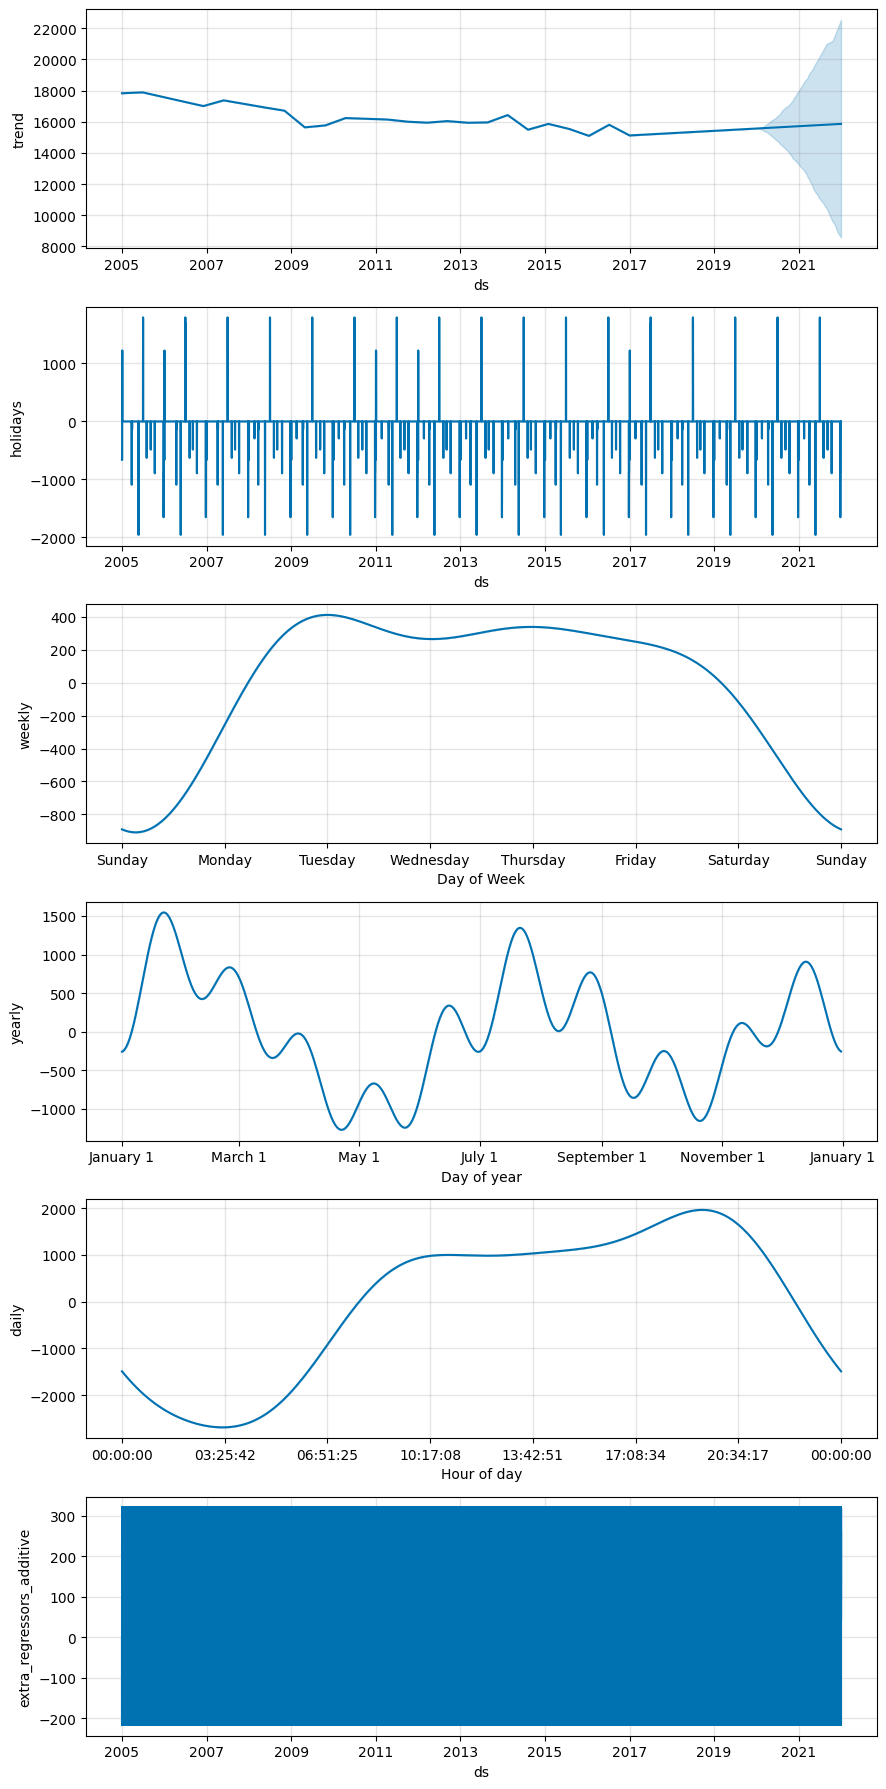

In [270]:
model.plot_components(forecast);

In [271]:
forecast_corrected = forecast.copy()

### Checking Performance of Short term Model

### Out-of-sample 

In [272]:
# Merge actual and predicted values
print("These are values for the short term model with regressors:\n")
performance_multivaraite_1 = pd.merge(new_stm_df[-len(test_set):], forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-len(test_set):], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivaraite_1['y'], performance_multivaraite_1['yhat'])
print(f'The MAE for the performance_multivaraite_1 is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivaraite_MAPE = mean_absolute_percentage_error(performance_multivaraite_1['y'], performance_multivaraite_1['yhat'])
print(f'The MAPE for the performance_multivaraite_1 is {performance_multivaraite_MAPE *100 }')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_multivaraite_1['y'], performance_multivaraite_1['yhat']))
print(f'The RMSE for the performance_multivaraite_1 is {performance_baseline_RMSE}')

These are values for the short term model with regressors:

The MAE for the performance_multivaraite_1 is 1403.7965592094777
The MAPE for the performance_multivaraite_1 is 9.564600260784143
The RMSE for the performance_multivaraite_1 is 1784.080669775593


### Insample test

In [273]:
# Merge actual and predicted values
print("These are values for the short term model with regressors:\n")
performance_multivaraite_1 = pd.merge(new_stm_df[:-len(test_set)], forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][:-len(test_set)], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivaraite_1['y'], performance_multivaraite_1['yhat'])
print(f'The MAE for the performance_multivaraite_1 is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivaraite_MAPE = mean_absolute_percentage_error(performance_multivaraite_1['y'], performance_multivaraite_1['yhat'])
print(f'The MAPE for the performance_multivaraite_1 is {performance_multivaraite_MAPE *100}')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_multivaraite_1['y'], performance_multivaraite_1['yhat']))
print(f'The RMSE for the performance_multivaraite_1 is {performance_baseline_RMSE}')

These are values for the short term model with regressors:

The MAE for the performance_multivaraite_1 is 1185.2851246909268
The MAPE for the performance_multivaraite_1 is 7.349371991432589
The RMSE for the performance_multivaraite_1 is 1544.9580463801717


In [274]:
performance_multivaraite_1.to_csv("performance_multivaraite_1.csv")

### Mid Term Model

In [275]:
data = pd.read_csv("combined_data_1.csv", date_parser=["Date"])
data["Date"] = pd.to_datetime(data['Date'], format='mixed')
#data["new_date"] = data["Date"].dt.strftime('%Y-%m-%d %H:%M:%S')
data.head()

C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\1286839990.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv("combined_data_1.csv", date_parser=["Date"])


,Date,Hour,Ontario Demand
0,2005-01-01,1,15016
1,2005-01-01,2,14470
2,2005-01-01,3,14015
3,2005-01-01,4,13622
4,2005-01-01,5,13545


In [276]:
data.rename(columns={"Date":"ds", "Ontario Demand":"y"},inplace=True)

In [277]:
data = data.set_index(pd.DatetimeIndex(data['ds']))
data = data.resample("D").mean()
data["ds"] = data["ds"].dt.date
data.head()

,ds,Hour,y
ds,,,
2005-01-01,2005-01-01,12.5,15781.583333
2005-01-02,2005-01-02,12.5,19731.041667
2005-01-03,2005-01-03,12.5,19397.791667
2005-01-04,2005-01-04,12.5,17145.291667
2005-01-05,2005-01-05,12.5,14662.208333


In [278]:
temp =  pd.read_csv("Temperature_data.csv")
temp = temp.rename(columns={"Unnamed: 0":"Date"})
temp["Date"] = pd.to_datetime(temp['Date'], format='mixed')
temp = temp.set_index(pd.DatetimeIndex(temp['Date']))
temp = pd.DataFrame(temp)


In [279]:
temp = temp[["Date","Total_temperature"]]

In [280]:
temp.rename(columns={"Total_temperature" : "weighted_temperature"},inplace=True)

In [281]:
temp = temp.resample("D").mean()

In [282]:
#temp =  pd.read_csv("Temperatures.csv")
#temp = temp.rename(columns={"Unnamed: 0":"Date"})
#temp["Date"] = pd.to_datetime(temp['Date'], format='mixed')
#temp = temp.set_index(pd.DatetimeIndex(temp['Date']))
#temp = pd.DataFrame(temp)
#temp = temp[["Date","Total_temperature"]]
#temp = temp["weighted_mean_temperature"]
#temp.rename(columns={"weighted_mean_temperature" : "weighted_temperature"},inplace=True)
#df.rename(columns={'old_column_name': 'new_column_name'}, inplace=True)


In [283]:
def orakle_mid_term_lm(midterm_all_data):

    #midterm_all_data["Date"] = pd.to_datetime(midterm_all_data["Date"])
    #midterm_all_data = midterm_all_data.resample("D").mean()
    midterm_all_data["month"] = midterm_all_data["ds"].dt.month
    midterm_all_data["day"] = midterm_all_data["ds"].dt.day

    month_list = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Nov", "Dec"]
    
    for month in month_list:
        midterm_all_data[month] = 0
        midterm_all_data.loc[midterm_all_data["month"] == month_list.index(month)+1, month] = 1
    
    midterm_all_data["wday"] = midterm_all_data["ds"].dt.day_name()
    weekday_list = midterm_all_data["wday"].unique().astype(str)


    for weekday in weekday_list:
        midterm_all_data[weekday] = 0
        midterm_all_data.loc[midterm_all_data["wday"] == weekday, weekday] = 1

    midterm_all_data["HD"] = 0
    midterm_all_data["CD"] = 0


    for i in range(len(midterm_all_data)):
        if midterm_all_data["weighted_temperature"].iloc[i] < 18:
            midterm_all_data["HD"].iloc[i] = 18 - midterm_all_data["weighted_temperature"].iloc[i]
        else:
            midterm_all_data["CD"].iloc[i] = midterm_all_data["weighted_temperature"].iloc[i] - 18


    midterm_all_data["HD2"] = midterm_all_data["HD"] ** 2
    midterm_all_data["HD3"] = midterm_all_data["HD"] ** 3
    midterm_all_data["CD2"] = midterm_all_data["CD"] ** 2
    midterm_all_data["CD3"] = midterm_all_data["CD"] ** 3
    midterm_all_data["weighted_temperature2"] = midterm_all_data["weighted_temperature"] ** 2
    midterm_all_data["weighted_temperature3"] = midterm_all_data["weighted_temperature"] ** 3
    
    midterm_all_data["HDlag1"] = midterm_all_data["HD"].shift(1)
    midterm_all_data["HDlag1"].iloc[0] = midterm_all_data["HD"].iloc[0]
    midterm_all_data["HDlag2"] = midterm_all_data["HD"].shift(2)
    midterm_all_data["HDlag2"].iloc[:2] = midterm_all_data["HDlag1"].iloc[:2]
    
    midterm_all_data["CDlag1"] = midterm_all_data["CD"].shift(1)
    midterm_all_data["CDlag1"].iloc[0] = midterm_all_data["CD"].iloc[0]
    midterm_all_data["CDlag2"] = midterm_all_data["CD"].shift(2)
    midterm_all_data["CDlag2"].iloc[:2] = midterm_all_data["CDlag1"].iloc[:2]
    
    midterm_all_data["weighted_temperaturelag1"] = midterm_all_data["weighted_temperature"].shift(1)
    midterm_all_data["weighted_temperaturelag1"].iloc[0] = midterm_all_data["weighted_temperature"].iloc[0]
    midterm_all_data["weighted_temperaturelag2"] = midterm_all_data["weighted_temperature"].shift(2)
    midterm_all_data["weighted_temperaturelag2"].iloc[:2] = midterm_all_data["weighted_temperaturelag1"].iloc[:2]
    
    midterm_all_data["end_of_year"] = 0
    midterm_all_data.loc[(midterm_all_data["month"] == 12) & (midterm_all_data["day"] > 22), "end_of_year"] = 1

    
    
    return midterm_all_data

In [284]:
print(data.shape, temp.shape)

(6209, 3) (6209, 2)


In [285]:
if len(data) == len(temp):
    merged_df = pd.concat([data, temp], axis=1)  # Concatenate along the columns (axis=1)

    # Optional: Reset the index of the merged DataFrame
    merged_df.reset_index(drop=True, inplace=True)

    print(merged_df)
else:
    print("DataFrames have different number of rows. Cannot merge.")

              ds  Hour             y                Date  weighted_temperature
0     2005-01-01  12.5  15781.583333 2005-01-01 11:30:00              3.821227
1     2005-01-02  12.5  19731.041667 2005-01-02 11:30:00             -1.105759
2     2005-01-03  12.5  19397.791667 2005-01-03 11:30:00              2.832510
3     2005-01-04  12.5  17145.291667 2005-01-04 11:30:00              0.813166
4     2005-01-05  12.5  14662.208333 2005-01-05 11:30:00             -3.005091
...          ...   ...           ...                 ...                   ...
6204  2021-12-27  12.5  15816.333333 2021-12-27 11:30:00             -3.903067
6205  2021-12-28  12.5  15659.541667 2021-12-28 11:30:00             -0.076809
6206  2021-12-29  12.5  15733.666667 2021-12-29 11:30:00              0.484030
6207  2021-12-30  12.5  15618.625000 2021-12-30 11:30:00              1.136811
6208  2021-12-31  12.5  15085.666667 2021-12-31 11:30:00              2.811064

[6209 rows x 5 columns]


In [286]:
joined_df = merged_df

In [287]:
to_drop = joined_df[["Hour","Date"]]

In [288]:
joined_df.drop(columns=to_drop, inplace=True)

In [289]:
def create_day_type_columns(df):
    # Convert the date column to datetime type if it's not already
    df["ds"] = pd.to_datetime(df["ds"])

    # Get the day of the week for each date
    df['DayOfWeek'] = df["ds"].dt.day_name()

    # Create separate columns for each day of the week and assign 1 when the day matches, else 0
    for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
        df[day] = (df['DayOfWeek'] == day).astype(int)

    # Drop the temporary 'DayOfWeek' column
    df.drop('DayOfWeek', axis=1, inplace=True)

    return df

In [290]:
joined_df = create_day_type_columns(joined_df)

In [291]:
joined_df["ds"] = pd.to_datetime(joined_df['ds'], format='mixed')
#temp = temp.set_index(pd.DatetimeIndex(temp['Date']))

In [292]:
orakle_mid_term_lm(joined_df)

C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\279268669.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midterm_all_data["HD"].iloc[i] = 18 - midterm_all_data["weighted_temperature"].iloc[i]
C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\279268669.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  midterm_all_data["CD"].iloc[i] = midterm_all_data["weighted_temperature"].iloc[i] - 18
C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\279268669.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

,ds,y,weighted_temperature,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,...,CD3,weighted_temperature2,weighted_temperature3,HDlag1,HDlag2,CDlag1,CDlag2,weighted_temperaturelag1,weighted_temperaturelag2,end_of_year
0,2005-01-01,15781.583333,3.821227,0,0,0,0,0,1,0,...,0.0,14.601773,55.796683,14.178773,14.178773,0.0,0.0,3.821227,3.821227,0
1,2005-01-02,19731.041667,-1.105759,0,0,0,0,0,0,1,...,0.0,1.222703,-1.352016,14.178773,14.178773,0.0,0.0,3.821227,3.821227,0
2,2005-01-03,19397.791667,2.832510,1,0,0,0,0,0,0,...,0.0,8.023112,22.725544,19.105759,14.178773,0.0,0.0,-1.105759,3.821227,0
3,2005-01-04,17145.291667,0.813166,0,1,0,0,0,0,0,...,0.0,0.661239,0.537697,15.167490,19.105759,0.0,0.0,2.832510,-1.105759,0
4,2005-01-05,14662.208333,-3.005091,0,0,1,0,0,0,0,...,0.0,9.030574,-27.137700,17.186834,15.167490,0.0,0.0,0.813166,2.832510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6204,2021-12-27,15816.333333,-3.903067,1,0,0,0,0,0,0,...,0.0,15.233933,-59.459061,15.714167,15.598410,0.0,0.0,2.285833,2.401590,1
6205,2021-12-28,15659.541667,-0.076809,0,1,0,0,0,0,0,...,0.0,0.005900,-0.000453,21.903067,15.714167,0.0,0.0,-3.903067,2.285833,1
6206,2021-12-29,15733.666667,0.484030,0,0,1,0,0,0,0,...,0.0,0.234285,0.113401,18.076809,21.903067,0.0,0.0,-0.076809,-3.903067,1
6207,2021-12-30,15618.625000,1.136811,0,0,0,1,0,0,0,...,0.0,1.292340,1.469147,17.515970,18.076809,0.0,0.0,0.484030,-0.076809,1


In [293]:
selected_dtypes = joined_df.select_dtypes(include=["datetime64[ns]","float","int64"])
selected_dtypes

,ds,y,weighted_temperature,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,...,CD3,weighted_temperature2,weighted_temperature3,HDlag1,HDlag2,CDlag1,CDlag2,weighted_temperaturelag1,weighted_temperaturelag2,end_of_year
0,2005-01-01,15781.583333,3.821227,0,0,0,0,0,1,0,...,0.0,14.601773,55.796683,14.178773,14.178773,0.0,0.0,3.821227,3.821227,0
1,2005-01-02,19731.041667,-1.105759,0,0,0,0,0,0,1,...,0.0,1.222703,-1.352016,14.178773,14.178773,0.0,0.0,3.821227,3.821227,0
2,2005-01-03,19397.791667,2.832510,1,0,0,0,0,0,0,...,0.0,8.023112,22.725544,19.105759,14.178773,0.0,0.0,-1.105759,3.821227,0
3,2005-01-04,17145.291667,0.813166,0,1,0,0,0,0,0,...,0.0,0.661239,0.537697,15.167490,19.105759,0.0,0.0,2.832510,-1.105759,0
4,2005-01-05,14662.208333,-3.005091,0,0,1,0,0,0,0,...,0.0,9.030574,-27.137700,17.186834,15.167490,0.0,0.0,0.813166,2.832510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6204,2021-12-27,15816.333333,-3.903067,1,0,0,0,0,0,0,...,0.0,15.233933,-59.459061,15.714167,15.598410,0.0,0.0,2.285833,2.401590,1
6205,2021-12-28,15659.541667,-0.076809,0,1,0,0,0,0,0,...,0.0,0.005900,-0.000453,21.903067,15.714167,0.0,0.0,-3.903067,2.285833,1
6206,2021-12-29,15733.666667,0.484030,0,0,1,0,0,0,0,...,0.0,0.234285,0.113401,18.076809,21.903067,0.0,0.0,-0.076809,-3.903067,1
6207,2021-12-30,15618.625000,1.136811,0,0,0,1,0,0,0,...,0.0,1.292340,1.469147,17.515970,18.076809,0.0,0.0,0.484030,-0.076809,1


In [294]:
#to_drop = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Nov", "Dec"]

In [295]:
#selected_dtypes.drop(columns=to_drop, inplace=True)

In [296]:
variable_list = selected_dtypes.iloc[:,3:]
variable_list

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Jan,Feb,Mar,...,CD3,weighted_temperature2,weighted_temperature3,HDlag1,HDlag2,CDlag1,CDlag2,weighted_temperaturelag1,weighted_temperaturelag2,end_of_year
0,0,0,0,0,0,1,0,1,0,0,...,0.0,14.601773,55.796683,14.178773,14.178773,0.0,0.0,3.821227,3.821227,0
1,0,0,0,0,0,0,1,1,0,0,...,0.0,1.222703,-1.352016,14.178773,14.178773,0.0,0.0,3.821227,3.821227,0
2,1,0,0,0,0,0,0,1,0,0,...,0.0,8.023112,22.725544,19.105759,14.178773,0.0,0.0,-1.105759,3.821227,0
3,0,1,0,0,0,0,0,1,0,0,...,0.0,0.661239,0.537697,15.167490,19.105759,0.0,0.0,2.832510,-1.105759,0
4,0,0,1,0,0,0,0,1,0,0,...,0.0,9.030574,-27.137700,17.186834,15.167490,0.0,0.0,0.813166,2.832510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6204,1,0,0,0,0,0,0,0,0,0,...,0.0,15.233933,-59.459061,15.714167,15.598410,0.0,0.0,2.285833,2.401590,1
6205,0,1,0,0,0,0,0,0,0,0,...,0.0,0.005900,-0.000453,21.903067,15.714167,0.0,0.0,-3.903067,2.285833,1
6206,0,0,1,0,0,0,0,0,0,0,...,0.0,0.234285,0.113401,18.076809,21.903067,0.0,0.0,-0.076809,-3.903067,1
6207,0,0,0,1,0,0,0,0,0,0,...,0.0,1.292340,1.469147,17.515970,18.076809,0.0,0.0,0.484030,-0.076809,1


In [297]:
selected_dtypes.columns

Index(['ds', 'y', 'weighted_temperature', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'Jan', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Nov', 'Dec', 'HD', 'CD', 'HD2',
       'HD3', 'CD2', 'CD3', 'weighted_temperature2', 'weighted_temperature3',
       'HDlag1', 'HDlag2', 'CDlag1', 'CDlag2', 'weighted_temperaturelag1',
       'weighted_temperaturelag2', 'end_of_year'],
      dtype='object')

In [298]:
data_1 = selected_dtypes

In [299]:
data_1["ds"] = pd.to_datetime(data_1["ds"], format="mixed")
data_1 = data_1.set_index(pd.DatetimeIndex(data_1['ds']))

In [300]:
df_mtm = data_1[["ds","y"]]
#df_mtm.rename(columns={"Daily_demand_trend_corrected":"y"})

In [301]:
new_variables = data_1.iloc[:,3:]

In [302]:
new_variables.shape

(6209, 33)

In [303]:
new_mtm_df = pd.concat([df_mtm, new_variables], axis=1)

In [304]:
#new_mtm_df = new_mtm_df.rename(columns={"Daily_demand_trend_corrected":"y"})

In [305]:
new_mtm_df.columns

Index(['ds', 'y', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Nov', 'Dec', 'HD', 'CD', 'HD2', 'HD3', 'CD2', 'CD3',
       'weighted_temperature2', 'weighted_temperature3', 'HDlag1', 'HDlag2',
       'CDlag1', 'CDlag2', 'weighted_temperaturelag1',
       'weighted_temperaturelag2', 'end_of_year'],
      dtype='object')

In [306]:
df = new_mtm_df
df.reset_index(drop=True, inplace=True)

In [307]:
# Sort the DataFrame by the 'date' column in ascending order
df.sort_values('ds', inplace=True)

# Split the DataFrame into train and test sets
train_start_date = '2005-01-01'
train_end_date = '2019-12-31'
test_start_date = '2020-01-01'

train_set = df[(df['ds'] >= train_start_date) & (df['ds'] <= train_end_date)]
test_set = df[df['ds'] >= test_start_date]

# If you want to reset the index of the new DataFrames
#train_set.reset_index(drop=True, inplace=True)
#test_set.reset_index(drop=True, inplace=True)

In [308]:
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))

Train set length: 5478
Test set length: 731


In [309]:
model_multivariate_2 = Prophet(interval_width=0.95, yearly_seasonality=True)

In [310]:
# Add regressor
#model_multivariate.add_regressor("Total_temperature", standardize=False)

for i in variable_list.columns:
    model_multivariate_2.add_regressor(i)

model_multivariate_2.add_country_holidays(country_name="CA")

In [311]:
# Fit the model on the trainin set
model_multivariate_2.fit(train_set)

17:56:28 - cmdstanpy - INFO - Chain [1] start processing


17:56:30 - cmdstanpy - INFO - Chain [1] done processing


In [312]:
future_multivariate = model_multivariate_2.make_future_dataframe(freq="D", periods= 731 )
future_multivariate

,ds
0,2005-01-01
1,2005-01-02
2,2005-01-03
3,2005-01-04
4,2005-01-05
...,...
6204,2021-12-27
6205,2021-12-28
6206,2021-12-29
6207,2021-12-30


In [313]:
future_multivariate = pd.merge(future_multivariate, df , on="ds", how = "inner")

In [314]:
future_multivariate

,ds,y,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Jan,...,CD3,weighted_temperature2,weighted_temperature3,HDlag1,HDlag2,CDlag1,CDlag2,weighted_temperaturelag1,weighted_temperaturelag2,end_of_year
0,2005-01-01,15781.583333,0,0,0,0,0,1,0,1,...,0.0,14.601773,55.796683,14.178773,14.178773,0.0,0.0,3.821227,3.821227,0
1,2005-01-02,19731.041667,0,0,0,0,0,0,1,1,...,0.0,1.222703,-1.352016,14.178773,14.178773,0.0,0.0,3.821227,3.821227,0
2,2005-01-03,19397.791667,1,0,0,0,0,0,0,1,...,0.0,8.023112,22.725544,19.105759,14.178773,0.0,0.0,-1.105759,3.821227,0
3,2005-01-04,17145.291667,0,1,0,0,0,0,0,1,...,0.0,0.661239,0.537697,15.167490,19.105759,0.0,0.0,2.832510,-1.105759,0
4,2005-01-05,14662.208333,0,0,1,0,0,0,0,1,...,0.0,9.030574,-27.137700,17.186834,15.167490,0.0,0.0,0.813166,2.832510,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6204,2021-12-27,15816.333333,1,0,0,0,0,0,0,0,...,0.0,15.233933,-59.459061,15.714167,15.598410,0.0,0.0,2.285833,2.401590,1
6205,2021-12-28,15659.541667,0,1,0,0,0,0,0,0,...,0.0,0.005900,-0.000453,21.903067,15.714167,0.0,0.0,-3.903067,2.285833,1
6206,2021-12-29,15733.666667,0,0,1,0,0,0,0,0,...,0.0,0.234285,0.113401,18.076809,21.903067,0.0,0.0,-0.076809,-3.903067,1
6207,2021-12-30,15618.625000,0,0,0,1,0,0,0,0,...,0.0,1.292340,1.469147,17.515970,18.076809,0.0,0.0,0.484030,-0.076809,1


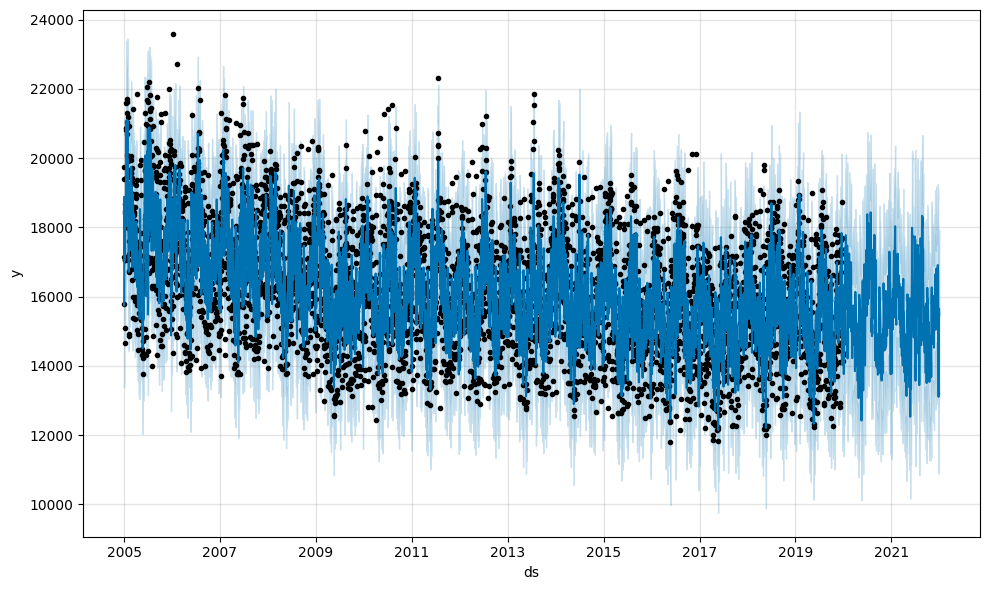

In [315]:
# Make prediction
forecast_multivaraite_2 = model_multivariate_2.predict(future_multivariate)
model_multivariate_2.plot(forecast_multivaraite_2);

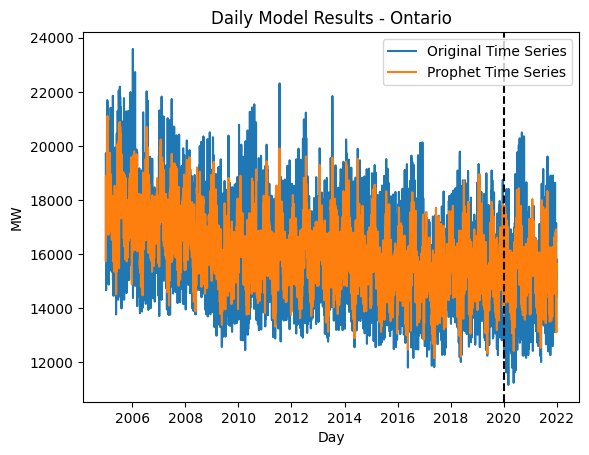

In [316]:
plt.plot(df["ds"], df["y"], label='Original Time Series')

# Plotting the second time series
plt.plot(forecast_multivaraite_2["ds"], forecast_multivaraite_2["yhat"], label='Prophet Time Series')

# Set the labels and title for the plot
plt.xlabel('Day')
plt.ylabel('MW')
plt.title('Daily Model Results - Ontario')
plt.axvline(x=test_set["ds"].iloc[0], linestyle="--", color="black")
# Display the legend
plt.legend()

# Display the plot
plt.show()

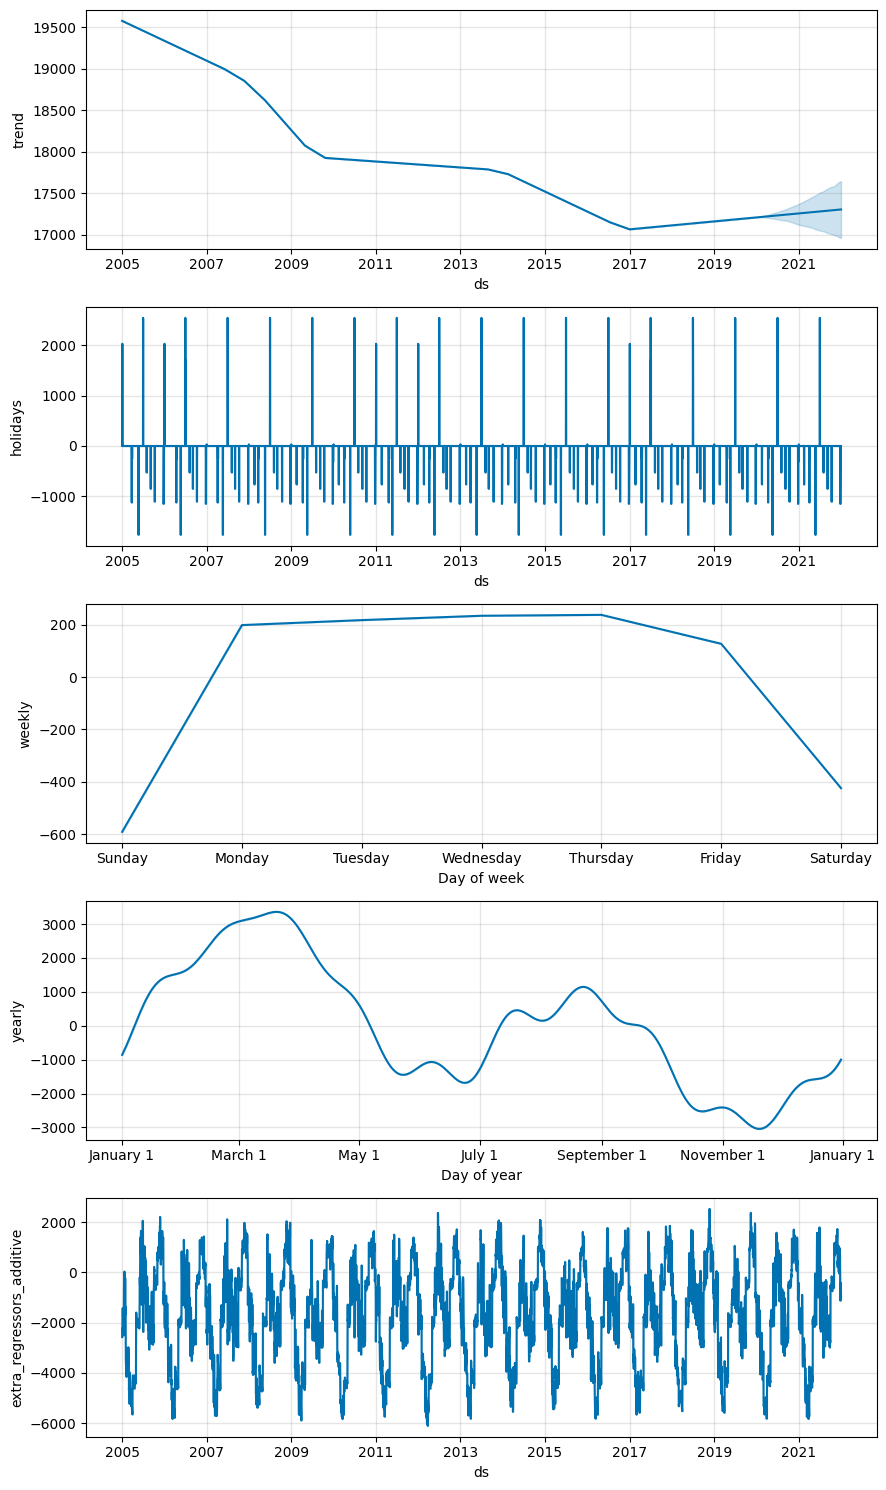

In [317]:
model_multivariate_2.plot_components(forecast_multivaraite_2);

### Out-of-sample

In [318]:
# Merge actual and predicted values
print("These are values for the short term model with regressors:\n")
performance_multivaraite_2 = pd.merge(test_set[-len(test_set):], forecast_multivaraite_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-len(test_set):], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivaraite_2['y'], performance_multivaraite_2['yhat'])
print(f'The MAE for the performance_multivaraite_2 is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivaraite_MAPE = mean_absolute_percentage_error(performance_multivaraite_2['y'], performance_multivaraite_2['yhat'])
print(f'The MAPE for the performance_multivaraite_2 is {performance_multivaraite_MAPE *100}')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_multivaraite_2['y'], performance_multivaraite_2['yhat']))
print(f'The RMSE for the performance_multivaraite_2 is {performance_baseline_RMSE}')

These are values for the short term model with regressors:

The MAE for the performance_multivaraite_2 is 956.6564691213255
The MAPE for the performance_multivaraite_2 is 6.590287773504162
The RMSE for the performance_multivaraite_2 is 1354.0382887629823


### In of sample test

In [319]:
# Merge actual and predicted values
print("These are values for the short term model with regressors:\n")
performance_multivaraite_2 = pd.merge(train_set[:-len(test_set)], forecast_multivaraite_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][:-len(test_set)], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivaraite_2['y'], performance_multivaraite_2['yhat'])
print(f'The MAE for the performance_multivaraite_2 is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivaraite_MAPE = mean_absolute_percentage_error(performance_multivaraite_2['y'], performance_multivaraite_2['yhat'])
print(f'The MAPE for the performance_multivaraite_2 is {performance_multivaraite_MAPE *100}')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_multivaraite_2['y'], performance_multivaraite_2['yhat']))
print(f'The RMSE for the performance_multivaraite_2 is {performance_baseline_RMSE}')

These are values for the short term model with regressors:

The MAE for the performance_multivaraite_2 is 833.0952017602393
The MAPE for the performance_multivaraite_2 is 5.161481476708224
The RMSE for the performance_multivaraite_2 is 1195.7975336721736


### Long term model

In [320]:
data = pd.read_csv("combined_data_1.csv", date_parser=["Date"])
data["Date"] = pd.to_datetime(data['Date'], format='mixed')
data = pd.DataFrame(data)
data = data.set_index(pd.DatetimeIndex(data['Date']))
data = data.resample("Y").mean()
data.head()

C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\3221846787.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv("combined_data_1.csv", date_parser=["Date"])


,Date,Hour,Ontario Demand
Date,,,
2005-12-31,2005-07-02 00:00:00.000000128,12.5,17919.134703
2006-12-31,2006-07-02 00:00:00.000000000,12.5,17243.639384
2007-12-31,2007-07-02 00:00:00.000000000,12.5,17375.072717
2008-12-31,2008-07-01 12:00:00.000000000,12.5,16925.764117
2009-12-31,2009-07-02 00:00:00.000000000,12.5,15886.484475


In [321]:
data.reset_index(drop=True, inplace=True)

In [322]:
Economic = pd.read_csv("Macro_economic_data.csv", date_parser=["year"])
Economic = Economic.rename(columns={"year":"Date","Ontario Demand":"Demand"})
Economic.head()

C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\890377578.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  Economic = pd.read_csv("Macro_economic_data.csv", date_parser=["year"])


,country,Date,Demand,population,gdp,industrial,manuf,gdp_defl,service,household_con
0,Ontario,2005,156971620,12578931,596629.2,596629.2,104509,86.97,185033,332402
1,Ontario,2006,151054281,12700994,608043.8,608043.8,98699,88.69,193396,344037
2,Ontario,2007,152205637,12807208,613525.9,613525.9,91115,91.59,201332,353772
3,Ontario,2008,148675912,12927148,611784.2,611784.2,83692,92.61,201530,359840
4,Ontario,2009,139165604,13047485,591636.5,591636.5,72223,93.91,204114,361257


In [323]:
Economic.drop(columns="Date",inplace=True)

In [324]:
#ltm_new = pd.merge(data, Economic, on= "Date")
ltm_new = pd.concat([data,Economic] , axis=1)

In [325]:
ltm_new

,Date,Hour,Ontario Demand,country,Demand,population,gdp,industrial,manuf,gdp_defl,service,household_con
0,2005-07-02 00:00:00.000000128,12.5,17919.134703,Ontario,156971620,12578931,596629.2,596629.2,104509,86.97,185033,332402
1,2006-07-02 00:00:00.000000000,12.5,17243.639384,Ontario,151054281,12700994,608043.8,608043.8,98699,88.69,193396,344037
2,2007-07-02 00:00:00.000000000,12.5,17375.072717,Ontario,152205637,12807208,613525.9,613525.9,91115,91.59,201332,353772
3,2008-07-01 12:00:00.000000000,12.5,16925.764117,Ontario,148675912,12927148,611784.2,611784.2,83692,92.61,201530,359840
4,2009-07-02 00:00:00.000000000,12.5,15886.484475,Ontario,139165604,13047485,591636.5,591636.5,72223,93.91,204114,361257
5,2010-07-02 00:00:00.000000000,12.5,16232.285502,Ontario,142194821,13189339,609770.3,609770.3,78581,96.27,214467,378764
6,2011-07-02 00:00:00.000000000,12.5,16149.632420,Ontario,141470780,13308659,625936.9,625936.9,81281,98.29,216604,378534
7,2012-07-01 12:00:00.000000000,12.5,16084.666894,Ontario,141287714,13434943,634944.3,634944.3,79217,100.00,220495,386358
8,2013-07-02 00:00:00.000000000,12.5,16065.842922,Ontario,140736784,13558528,643937.0,643937.0,81059,100.85,224926,396048
9,2014-07-02 00:00:00.000000000,12.5,15959.340753,Ontario,139803825,13661314,659861.2,659861.2,83547,102.74,229931,407875


In [326]:
columns_to_drop = ["Hour","country","Demand"]

In [327]:
ltm_new.drop(columns=columns_to_drop,inplace=True)

In [328]:
data = ltm_new

In [329]:
data.columns

Index(['Date', 'Ontario Demand', 'population', 'gdp', 'industrial', 'manuf',
       'gdp_defl', 'service', 'household_con'],
      dtype='object')

In [330]:
data.shape

(17, 9)

In [331]:
df = pd.DataFrame(data)

<Axes: ylabel='Ontario Demand'>

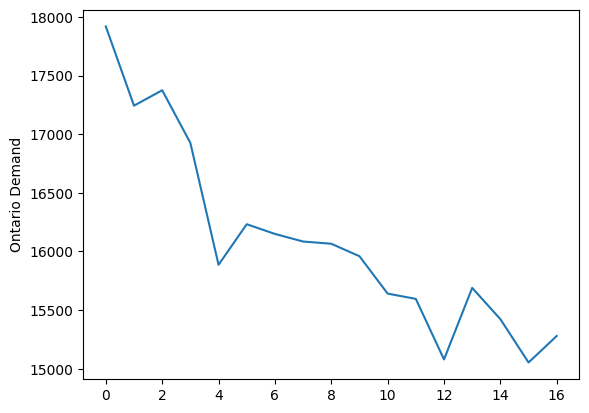

In [332]:
sns.lineplot(df["Ontario Demand"])

In [333]:
df = df.rename(columns={"Date":"ds","Ontario Demand":"y"})

### Performing Lasso Regression

In [334]:
# Separate the features (X) and the target variable (y) from the DataFrame
X = df.drop(columns=["ds","y"])

y = df["y"]

In [335]:

from locale import normalize


lasso = Lasso()
search = GridSearchCV(estimator=lasso, param_grid={"alpha":np.logspace(-10,2,10)},
                      scoring="neg_mean_squared_error",n_jobs=1, refit=True,cv=17)
search.fit(X,y)

c:\Users\SENANU\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e+05, tolerance: 7.379e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\SENANU\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e+05, tolerance: 9.513e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\SENANU\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

c:\Users\SENANU\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+05, tolerance: 1.087e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\SENANU\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e+05, tolerance: 1.090e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\SENANU\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

GridSearchCV(cv=17, estimator=Lasso(), n_jobs=1,
             param_grid={'alpha': array([1.00000000e-10, 2.15443469e-09, 4.64158883e-08, 1.00000000e-06,
       2.15443469e-05, 4.64158883e-04, 1.00000000e-02, 2.15443469e-01,
       4.64158883e+00, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [336]:
print(search.best_params_)
print(abs(search.best_score_))

{'alpha': 100.0}
79806.97060051259


In [337]:
# Initialize the Lasso regression model with a specific alpha (penalty) value
lasso = Lasso(alpha=400)  

In [338]:
# Fit the Lasso model to the data to perform feature selection
lasso.fit(X, y)

c:\Users\SENANU\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.206e+05, tolerance: 1.092e+03
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=400)

In [339]:
# Get the coefficients of the features from Lasso
selected_features = X.columns[lasso.coef_ != 0]

In [340]:
# Create a new DataFrame containing only the selected features and the target variable
prophet_data_selected = df[['ds', 'y'] + selected_features.tolist()]

In [341]:
df = prophet_data_selected 

In [342]:
df.dtypes

ds               datetime64[ns]
y                       float64
population                int64
gdp                     float64
industrial              float64
manuf                     int64
service                   int64
household_con             int64
dtype: object

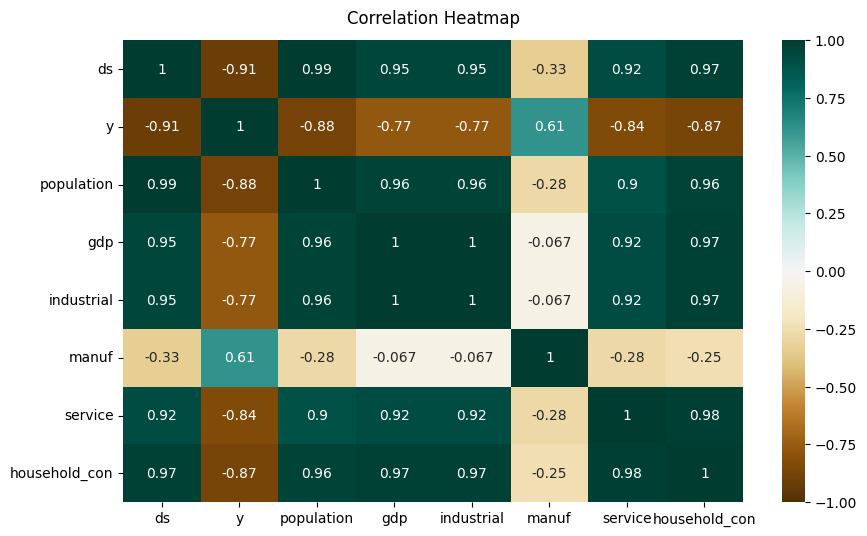

In [343]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
#sns.heatmap(df.corr())
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [344]:
df 

,ds,y,population,gdp,industrial,manuf,service,household_con
0,2005-07-02 00:00:00.000000128,17919.134703,12578931,596629.2,596629.2,104509,185033,332402
1,2006-07-02 00:00:00.000000000,17243.639384,12700994,608043.8,608043.8,98699,193396,344037
2,2007-07-02 00:00:00.000000000,17375.072717,12807208,613525.9,613525.9,91115,201332,353772
3,2008-07-01 12:00:00.000000000,16925.764117,12927148,611784.2,611784.2,83692,201530,359840
4,2009-07-02 00:00:00.000000000,15886.484475,13047485,591636.5,591636.5,72223,204114,361257
5,2010-07-02 00:00:00.000000000,16232.285502,13189339,609770.3,609770.3,78581,214467,378764
6,2011-07-02 00:00:00.000000000,16149.632420,13308659,625936.9,625936.9,81281,216604,378534
7,2012-07-01 12:00:00.000000000,16084.666894,13434943,634944.3,634944.3,79217,220495,386358
8,2013-07-02 00:00:00.000000000,16065.842922,13558528,643937.0,643937.0,81059,224926,396048
9,2014-07-02 00:00:00.000000000,15959.340753,13661314,659861.2,659861.2,83547,229931,407875


In [345]:
df["year"] = df["ds"].dt.year

In [346]:
columns_list = df.columns.tolist()
new_columns_order = [columns_list[-1]] + columns_list[:-1]
df = df[new_columns_order]

In [347]:
df = df.drop(columns="ds",axis=1)

In [348]:
df = df.rename(columns={"year":"ds"})

In [349]:
df["ds"] = df["ds"].astype(str) + "-12-31"
df["ds"] = pd.to_datetime(df["ds"])

In [350]:
df.dtypes

ds               datetime64[ns]
y                       float64
population                int64
gdp                     float64
industrial              float64
manuf                     int64
service                   int64
household_con             int64
dtype: object

In [351]:
train_set = df[df['ds'] <= "2019-12-31"]
test_set = df[df['ds']>  "2019-12-31"]

In [352]:
# Print the lengths of train and test sets
print("Train set length:", len(train_set))
print("Test set length:", len(test_set))

Train set length: 15
Test set length: 2


In [353]:
df.columns

Index(['ds', 'y', 'population', 'gdp', 'industrial', 'manuf', 'service',
       'household_con'],
      dtype='object')

In [354]:
df.dtypes

ds               datetime64[ns]
y                       float64
population                int64
gdp                     float64
industrial              float64
manuf                     int64
service                   int64
household_con             int64
dtype: object

In [355]:
#macroeconomic_variables = df.iloc[:,2:]
#macroeconomic_variables = df.iloc[:,2:6]
macroeconomic_variables = df.iloc[:,2:]
macroeconomic_variables

,population,gdp,industrial,manuf,service,household_con
0,12578931,596629.2,596629.2,104509,185033,332402
1,12700994,608043.8,608043.8,98699,193396,344037
2,12807208,613525.9,613525.9,91115,201332,353772
3,12927148,611784.2,611784.2,83692,201530,359840
4,13047485,591636.5,591636.5,72223,204114,361257
5,13189339,609770.3,609770.3,78581,214467,378764
6,13308659,625936.9,625936.9,81281,216604,378534
7,13434943,634944.3,634944.3,79217,220495,386358
8,13558528,643937.0,643937.0,81059,224926,396048
9,13661314,659861.2,659861.2,83547,229931,407875


In [356]:
model_multivariate_3 = Prophet(interval_width=0.95, yearly_seasonality=True, )

In [357]:
for i in macroeconomic_variables:
    model_multivariate_3.add_regressor(i)

In [358]:
model_multivariate_3.fit(train_set)

17:56:37 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing


In [359]:
model.params

OrderedDict([('lp__', array([[310054.]])),
             ('k', array([[0.0715824]])),
             ('m', array([[0.660238]])),
             ('delta',
              array([[-4.08698e-01, -1.47987e-06, -1.47050e-02,  7.81900e-01,
                      -6.95414e-01,  7.19512e-03,  2.00117e-02, -1.00849e+00,
                       1.38205e+00,  4.20124e-01, -6.13489e-01,  1.98716e-02,
                      -1.29932e-01,  8.47300e-02,  2.09081e-01, -2.54729e-01,
                       1.47873e-01,  5.39700e-01, -1.65241e+00,  1.53076e+00,
                      -7.96492e-01, -1.78540e-01,  1.37089e+00, -1.63197e+00,
                       8.81412e-01]])),
             ('sigma_obs', array([[0.057206]])),
             ('beta',
              array([[-1.48500e-03,  9.25748e-03,  2.10680e-02,  1.96422e-02,
                      -5.66586e-03, -4.79380e-03,  7.22785e-05, -2.80272e-03,
                       1.44028e-03, -3.58234e-03,  1.24158e-03, -4.01307e-03,
                      -1.45545e-04, -2

In [360]:
print(len(train_set), len(test_set))

15 2


In [361]:
test_set.tail()

,ds,y,population,gdp,industrial,manuf,service,household_con
15,2020-12-31,15052.985428,14721852,716151.8,716151.8,81644,224736,432290
16,2021-12-31,15279.019406,14901607,752340.8,752340.8,83642,250784,459230


In [362]:
future_multivariate_3 = model_multivariate_3.make_future_dataframe(freq="Y", periods= 2)
future_multivariate_3

,ds
0,2005-12-31
1,2006-12-31
2,2007-12-31
3,2008-12-31
4,2009-12-31
5,2010-12-31
6,2011-12-31
7,2012-12-31
8,2013-12-31
9,2014-12-31


In [363]:
#future_model_3 = pd.merge(future_multivariate_3, df[['ds', 'y', 'population', 'gdp', 'industrial', 'manuf', 'gdp_defl','service', 'household_con']] , on="ds")

In [364]:
future_model_3 = pd.merge(future_multivariate_3, df[['ds', 'y', 'population', 'gdp', 'manuf', 'industrial','service', 'household_con']] , on="ds")

In [365]:
future_model_3

,ds,y,population,gdp,manuf,industrial,service,household_con
0,2005-12-31,17919.134703,12578931,596629.2,104509,596629.2,185033,332402
1,2006-12-31,17243.639384,12700994,608043.8,98699,608043.8,193396,344037
2,2007-12-31,17375.072717,12807208,613525.9,91115,613525.9,201332,353772
3,2008-12-31,16925.764117,12927148,611784.2,83692,611784.2,201530,359840
4,2009-12-31,15886.484475,13047485,591636.5,72223,591636.5,204114,361257
5,2010-12-31,16232.285502,13189339,609770.3,78581,609770.3,214467,378764
6,2011-12-31,16149.632420,13308659,625936.9,81281,625936.9,216604,378534
7,2012-12-31,16084.666894,13434943,634944.3,79217,634944.3,220495,386358
8,2013-12-31,16065.842922,13558528,643937.0,81059,643937.0,224926,396048
9,2014-12-31,15959.340753,13661314,659861.2,83547,659861.2,229931,407875


In [366]:
forecast_3 = model_multivariate_3.predict(future_model_3)
forecast_3[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
12,2017-12-31,15338.004010,14975.928151,15690.931889
13,2018-12-31,15474.722631,15149.977780,15788.844468
14,2019-12-31,15479.489481,15144.857320,15812.455114
15,2020-12-31,15683.431209,15349.728158,15996.595073
16,2021-12-31,15357.227626,15037.871758,15672.290043


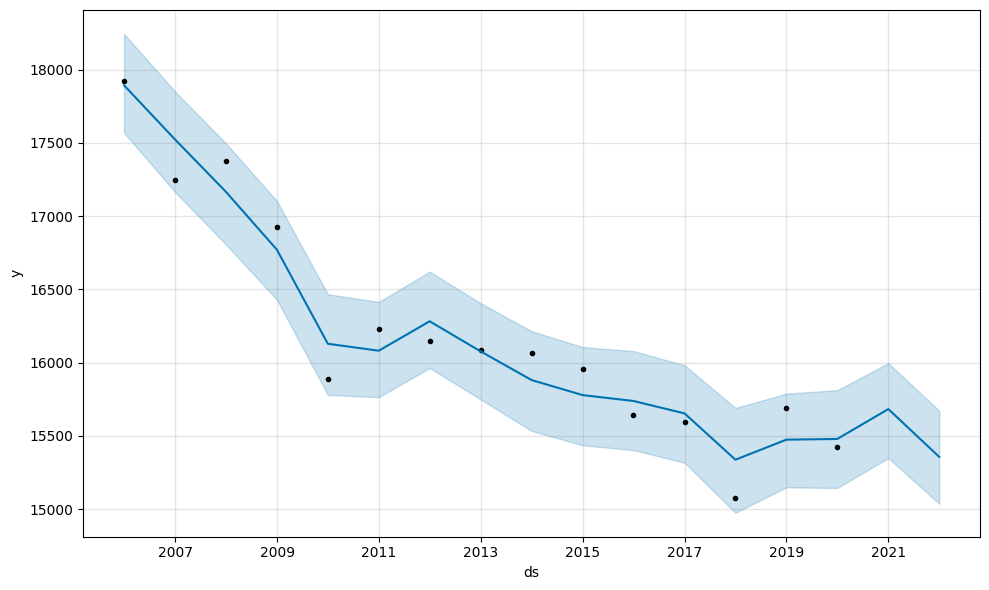

In [367]:
model_multivariate_3.plot(forecast_3);

In [368]:
forecast_3

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,service,service_lower,service_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-12-31,4905.560235,17567.619572,18242.636136,4905.560235,4905.560235,12986.760979,12986.760979,12986.760979,602.772814,...,146.818575,146.818575,146.818575,12383.988165,12383.988165,12383.988165,0.0,0.0,0.0,17892.321214
1,2006-12-31,4747.317103,17165.464198,17850.556852,4747.317103,4747.317103,12775.830244,12775.830244,12775.830244,388.972086,...,114.074038,114.074038,114.074038,12386.858157,12386.858157,12386.858157,0.0,0.0,0.0,17523.147347
2,2007-12-31,4589.073971,16806.683336,17496.933792,4589.073971,4589.073971,12576.997784,12576.997784,12576.997784,103.371380,...,83.001379,83.001379,83.001379,12473.626404,12473.626404,12473.626404,0.0,0.0,0.0,17166.071755
3,2008-12-31,4430.397290,16429.226810,17102.694738,4430.397290,4430.397290,12339.955001,12339.955001,12339.955001,-125.262479,...,82.226129,82.226129,82.226129,12465.217480,12465.217480,12465.217480,0.0,0.0,0.0,16770.352291
4,2009-12-31,4272.154150,15780.130594,16467.091847,4272.154150,4272.154150,11856.867463,11856.867463,11856.867463,-527.120701,...,72.108720,72.108720,72.108720,12383.988165,12383.988165,12383.988165,0.0,0.0,0.0,16129.021614
5,2010-12-31,4113.911011,15764.461620,16414.318138,4113.911011,4113.911011,11967.679190,11967.679190,11967.679190,-419.178968,...,31.572526,31.572526,31.572526,12386.858157,12386.858157,12386.858157,0.0,0.0,0.0,16081.590201
6,2011-12-31,3955.666647,15963.659612,16621.239573,3955.666647,3955.666647,12326.680901,12326.680901,12326.680901,-146.945502,...,23.205304,23.205304,23.205304,12473.626404,12473.626404,12473.626404,0.0,0.0,0.0,16282.347548
7,2012-12-31,3796.869514,15749.020333,16405.666418,3796.869514,3796.869514,12279.826940,12279.826940,12279.826940,-185.390540,...,7.970461,7.970461,7.970461,12465.217480,12465.217480,12465.217480,0.0,0.0,0.0,16076.696454
8,2013-12-31,3638.016130,15533.968115,16214.851094,3638.016130,3638.016130,12243.260829,12243.260829,12243.260829,-140.727336,...,-9.378702,-9.378702,-9.378702,12383.988165,12383.988165,12383.988165,0.0,0.0,0.0,15881.276959
9,2014-12-31,3477.109970,15436.337552,16106.669345,3477.109970,3477.109970,12301.729665,12301.729665,12301.729665,-85.128492,...,-28.975307,-28.975307,-28.975307,12386.858157,12386.858157,12386.858157,0.0,0.0,0.0,15778.839635


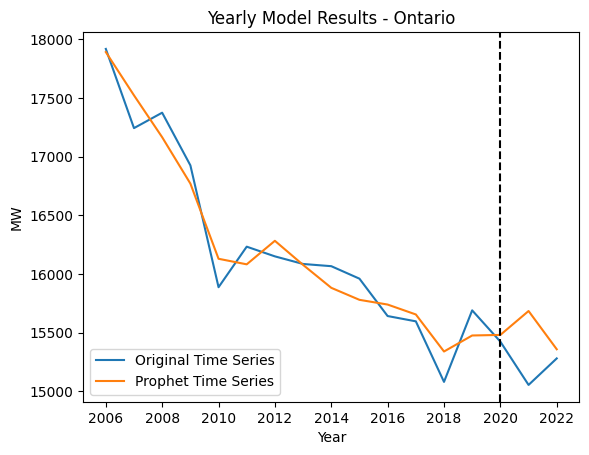

In [369]:
plt.plot(df["ds"], df["y"], label='Original Time Series')

# Plotting the second time series
plt.plot(forecast_3["ds"], forecast_3["yhat"], label='Prophet Time Series')

# Set the labels and title for the plot
plt.xlabel('Year')
plt.ylabel('MW')
plt.title('Yearly Model Results - Ontario')
plt.axvline(x=train_set["ds"].iloc[-1], linestyle="--", color="black")
# Display the legend
plt.legend()

# Display the plot
plt.show()

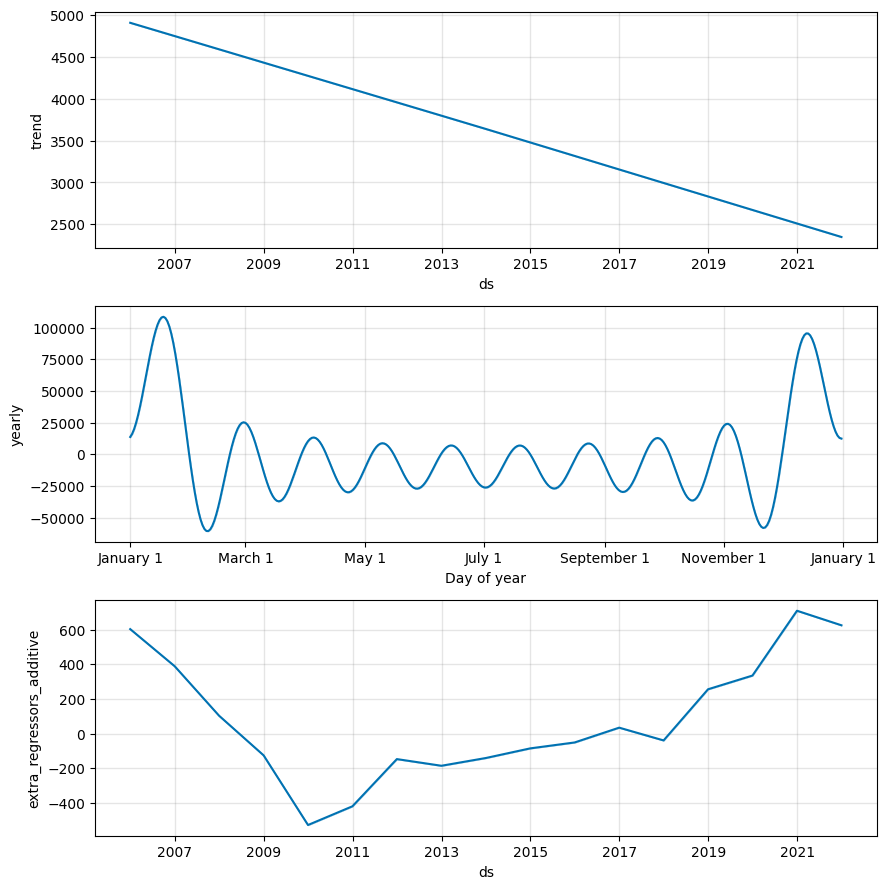

In [370]:
model_multivariate_3.plot_components(forecast_3);

### Out-of-sample evalutions 

In [371]:
# Merge actual and predicted values
performance_baseline = pd.merge(test_set[-len(test_set):], forecast_3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-len(test_set):], on='ds')
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE * 100}')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_baseline['y'], performance_baseline['yhat']))
print(f'The RMSE for the performance_multivaraite_2 is {performance_baseline_RMSE}')

The MAE for the baseline model is 354.3270005942377
The MAPE for the baseline model is 2.350022232450613
The RMSE for the performance_multivaraite_2 is 449.20953290612647


### In-Sample

In [372]:
# Merge actual and predicted values
performance_baseline = pd.merge(train_set[:-len(test_set)], forecast_3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][:-len(test_set)], on='ds')
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE*100}')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_baseline['y'], performance_baseline['yhat']))
print(f'The RMSE for the performance_multivaraite_2 is {performance_baseline_RMSE}')



The MAE for the baseline model is 152.7280954817863
The MAPE for the baseline model is 0.9399059544968487
The RMSE for the performance_multivaraite_2 is 173.8077893004988


### Combining all models

In [373]:
a = forecast.copy()

In [374]:
b = forecast_multivaraite_2.copy()

In [375]:
b.set_index("ds", inplace=True)
daily_df_resampled = b.resample('H').ffill()

In [376]:
print(a.shape, daily_df_resampled.shape)

(149016, 142) (148993, 168)


In [377]:
daily_df_resampled_1 = daily_df_resampled.iloc[[-1]].copy()

In [378]:
start_date = daily_df_resampled_1.index[-1] + pd.Timedelta(days=0)

end_date = pd.to_datetime(f'{start_date.year + 1}-01-01')
hourly_timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

# Create a new DataFrame with the hourly timestamps and the value of the last row in 'new_df'
daily_new = pd.DataFrame(index=hourly_timestamps, columns=daily_df_resampled_1.columns)
daily_new[daily_df_resampled_1.columns] = daily_df_resampled_1.iloc[0].values

# Forward-fill the missing values
daily_new.fillna(method='ffill', inplace=True)

In [379]:
daily_new.drop(daily_new.index[-1], inplace=True)

In [380]:
daily_df_resampled.drop(daily_df_resampled.index[-1], inplace=True)

In [381]:
daily_added = pd.concat([daily_df_resampled, daily_new])

In [382]:
daily_added = daily_added.reset_index()

In [383]:
daily_added.rename(columns={"index":"ds"},inplace=True)

In [384]:
print(a.shape, daily_added.shape)

(149016, 142) (149016, 169)


In [385]:
c = forecast_3.copy()

In [386]:
c.rename(columns={"ds":"Date"}, inplace=True)

In [387]:
c['Date'] = pd.to_datetime(c['Date'])

# Iterate through each date in the 'date' column and reset it to '2005-01-01'
for i in range(len(c)):
    c.at[i, 'Date'] = c.at[i, 'Date'] - pd.Timedelta(days=364)

In [388]:
def format_dates_to_first_day(df):
    # Convert the date column to pandas datetime format
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    
    # Extract year and month components
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    
    # Create new datetime with the first day of the month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    
    # Drop the temporary year and month columns
    df.drop(columns=['year', 'month'], inplace=True)
    
    return df

In [389]:
formatted_df = format_dates_to_first_day(c)

In [390]:
c = formatted_df

In [391]:
c["New_Date"] = c["Date"]

In [392]:
c.set_index("New_Date", inplace=True)

In [393]:
yearly_df_resampled = c.resample('H').ffill()

In [394]:
new_1 = yearly_df_resampled.iloc[[-1]].copy()

In [395]:
start_date = new_1.index[-1] + pd.Timedelta(days=0)

end_date = pd.to_datetime(f'{start_date.year + 1}-01-01')
hourly_timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

# Create a new DataFrame with the hourly timestamps and the value of the last row in 'new_df'
filled_df = pd.DataFrame(index=hourly_timestamps, columns=new_1.columns)
filled_df[new_1.columns] = new_1.iloc[0].values

# Forward-fill the missing values
filled_df.fillna(method='ffill', inplace=True)

In [396]:
yearly_df_resampled.drop(yearly_df_resampled.index[-1], inplace=True)

In [397]:
filled_df.drop(filled_df.index[-1:], inplace=True)

In [398]:

yearly_added = pd.concat([yearly_df_resampled, filled_df])

In [399]:
yearly_added.rename(columns={"Date":"ds"},inplace=True)

In [400]:
yearly_added = yearly_added.reset_index()

In [401]:
yearly_added.drop("ds",axis=1, inplace=True)

In [402]:
yearly_added.rename(columns={"index":"ds"}, inplace=True)

In [403]:
print(a.shape, daily_added.shape, yearly_added.shape)

(149016, 142) (149016, 169) (149016, 37)


In [404]:
#yearly_added.drop_duplicates(inplace=True)

In [405]:
print(a.shape, daily_added.shape, yearly_added.shape)

(149016, 142) (149016, 169) (149016, 37)


In [406]:
all_added = pd.DataFrame()

In [407]:
a1 = a[["ds","yhat"]]
b1 = daily_added[["ds","yhat"]]
c1 = yearly_added[["ds","yhat"]]

In [408]:
a1.to_csv("Hourly_Forecast_Prophet.csv")

In [409]:
b1.to_csv("Daily_Forecast_Prophet.csv")

In [410]:
c1.to_csv("Yearly_Forecast_Prophet.csv")

In [411]:
print(a1.tail(), b1.tail(),c1.tail())

                        ds          yhat
149011 2021-12-31 19:00:00  17686.978837
149012 2021-12-31 20:00:00  17570.019784
149013 2021-12-31 21:00:00  17201.662750
149014 2021-12-31 22:00:00  16283.526682
149015 2021-12-31 23:00:00  15071.386296                         ds          yhat
149011 2021-12-31 19:00:00  15459.470305
149012 2021-12-31 20:00:00  15459.470305
149013 2021-12-31 21:00:00  15459.470305
149014 2021-12-31 22:00:00  15459.470305
149015 2021-12-31 23:00:00  15459.470305                         ds          yhat
149011 2021-12-31 19:00:00  15357.227626
149012 2021-12-31 20:00:00  15357.227626
149013 2021-12-31 21:00:00  15357.227626
149014 2021-12-31 22:00:00  15357.227626
149015 2021-12-31 23:00:00  15357.227626


In [412]:
all_added = pd.merge(a1,b1, on="ds", how="outer")

In [413]:
all_added = pd.merge(all_added,c1, on="ds", how="outer")

In [414]:
all_added["mean"]  = all_added.iloc[:,1:].mean(axis=1)

In [415]:
all_added.shape

(149016, 5)

### Comparing model perfomance 

In [416]:
data = pd.read_csv("combined_data_1.csv")
data["Date"] = pd.to_datetime(data['Date'], format='mixed')
data.head()

,Date,Hour,Ontario Demand
0,2005-01-01,1,15016
1,2005-01-01,2,14470
2,2005-01-01,3,14015
3,2005-01-01,4,13622
4,2005-01-01,5,13545


In [417]:
#data.rename(columns={"Date":"ds"},inplace=True)

In [418]:
data.drop("Hour", axis=1, inplace=True)

In [419]:
date_range = pd.date_range(start='2005-01-01 00:00:00', end='2021-12-31 23:00:00', freq='H')

In [420]:
data["new_date"] = date_range

In [421]:
data.columns

Index(['Date', 'Ontario Demand', 'new_date'], dtype='object')

In [422]:
data.drop(columns="Date", inplace=True)

In [423]:
last_column = data.columns[-1]

# Move the last column to the first position using indexing
data = data[[last_column] + list(data.columns[:-1])]

In [424]:
data.rename(columns={"new_date":"ds"}, inplace=True)

In [425]:
print (all_added.shape, data.shape)

(149016, 5) (149016, 2)


In [426]:
result = pd.merge(all_added, data, on="ds",how="outer")

In [427]:
result.shape

(149016, 6)

In [428]:
#result_df.set_index("ds", inplace=True)

In [429]:
#result_df

In [430]:
# Merge actual and predicted values
performance_baseline = result
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['Ontario Demand'], performance_baseline['mean'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['Ontario Demand'], performance_baseline['mean'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE*100}')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_baseline['Ontario Demand'], performance_baseline['mean']))
print(f'The RMSE for the baseline model is {performance_baseline_RMSE}')

The MAE for the baseline model is 1444.5137623109624
The MAPE for the baseline model is 9.25505629873554
The RMSE for the baseline model is 1791.095247082549


In [431]:

#result.to_csv("Prophet_Combined_New.csv", index=True)

In [432]:
# Sort the DataFrame by the 'date' column in ascending order
result.sort_values('ds', inplace=True)

# Split the DataFrame into train and test sets
train_start_date = '2005-01-01'
train_end_date = '2019-12-31'
test_start_date = '2020-01-01'

train_set = result[(result['ds'] >= train_start_date) & (result['ds'] <= train_end_date)]
test_set = result[result['ds'] >= test_start_date]

# If you want to reset the index of the new DataFrames
#train_set.reset_index(drop=True, inplace=True)
#test_set.reset_index(drop=True, inplace=True)

### Insample test Prophet

In [433]:
# Merge actual and predicted values
performance_baseline = (train_set)
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['Ontario Demand'], performance_baseline['mean'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['Ontario Demand'], performance_baseline['mean'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE*100}')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_baseline['Ontario Demand'], performance_baseline['mean']))
print(f'The RMSE for the baseline model is {performance_baseline_RMSE}')

The MAE for the baseline model is 1437.6468509011677
The MAPE for the baseline model is 9.109126210508569
The RMSE for the baseline model is 1784.8453082162723


### Out of sample Prophet

In [434]:
# Merge actual and predicted values
performance_baseline = (test_set)
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['Ontario Demand'], performance_baseline['mean'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['Ontario Demand'], performance_baseline['mean'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE*100}')

# Checking RMSE
performance_baseline_RMSE = np.sqrt(mean_squared_error(performance_baseline['Ontario Demand'], performance_baseline['mean']))
print(f'The RMSE for the baseline model is {performance_baseline_RMSE}')

The MAE for the baseline model is 1496.6269611343728
The MAPE for the baseline model is 10.351469027205956
The RMSE for the baseline model is 1837.8453126989584


In [435]:
data = pd.read_csv("Prophet_Combined_New.csv", date_parser=["date"])


C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\1310889486.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv("Prophet_Combined_New.csv", date_parser=["date"])


In [436]:
data1 = data[["ds","mean"]]

In [437]:
data1.rename(columns={"mean":"y"},inplace=True)

C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\79134091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.rename(columns={"mean":"y"},inplace=True)


In [438]:

model = Prophet()
model.fit(data1)


# Forecast into the future with each model
future = model.make_future_dataframe(periods=24*365*9, freq='H')  # Forecasting 9 years into the future at hourly resolution

forecast = model.predict(future)


17:56:55 - cmdstanpy - INFO - Chain [1] start processing
17:58:35 - cmdstanpy - INFO - Chain [1] done processing


In [439]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
227851,2030-12-29 19:00:00,15980.768778,-5132.568997,37696.949448,-5133.680647,37481.441452,109.270669,109.270669,109.270669,691.362588,...,-317.438700,-317.438700,-317.438700,-264.653219,-264.653219,-264.653219,0.0,0.0,0.0,16090.039448
227852,2030-12-29 20:00:00,15980.773193,-4800.219628,37596.738949,-5134.292716,37482.148216,107.245181,107.245181,107.245181,663.186724,...,-290.324128,-290.324128,-290.324128,-265.617415,-265.617415,-265.617415,0.0,0.0,0.0,16088.018374
227853,2030-12-29 21:00:00,15980.777607,-5227.736849,37564.286607,-5134.904785,37482.854980,-44.043211,-44.043211,-44.043211,485.126441,...,-262.609197,-262.609197,-262.609197,-266.560456,-266.560456,-266.560456,0.0,0.0,0.0,15936.734396
227854,2030-12-29 22:00:00,15980.782022,-5474.383256,37150.982794,-5135.516853,37483.561743,-322.688221,-322.688221,-322.688221,179.250363,...,-234.456307,-234.456307,-234.456307,-267.482278,-267.482278,-267.482278,0.0,0.0,0.0,15658.093801
227855,2030-12-29 23:00:00,15980.786437,-5631.136452,37156.556149,-5136.128922,37484.268507,-650.832620,-650.832620,-650.832620,-176.421160,...,-206.028639,-206.028639,-206.028639,-268.382821,-268.382821,-268.382821,0.0,0.0,0.0,15329.953816


In [440]:
future_df = forecast.iloc[:, [0, -1]]

In [441]:
future_df

,ds,yhat
0,2005-01-01 00:00:00,17018.432004
1,2005-01-01 01:00:00,16757.710210
2,2005-01-01 02:00:00,16579.850308
3,2005-01-01 03:00:00,16477.892631
4,2005-01-01 04:00:00,16464.635402
...,...,...
227851,2030-12-29 19:00:00,16090.039448
227852,2030-12-29 20:00:00,16088.018374
227853,2030-12-29 21:00:00,15936.734396
227854,2030-12-29 22:00:00,15658.093801


In [442]:
future_df.columns

Index(['ds', 'yhat'], dtype='object')

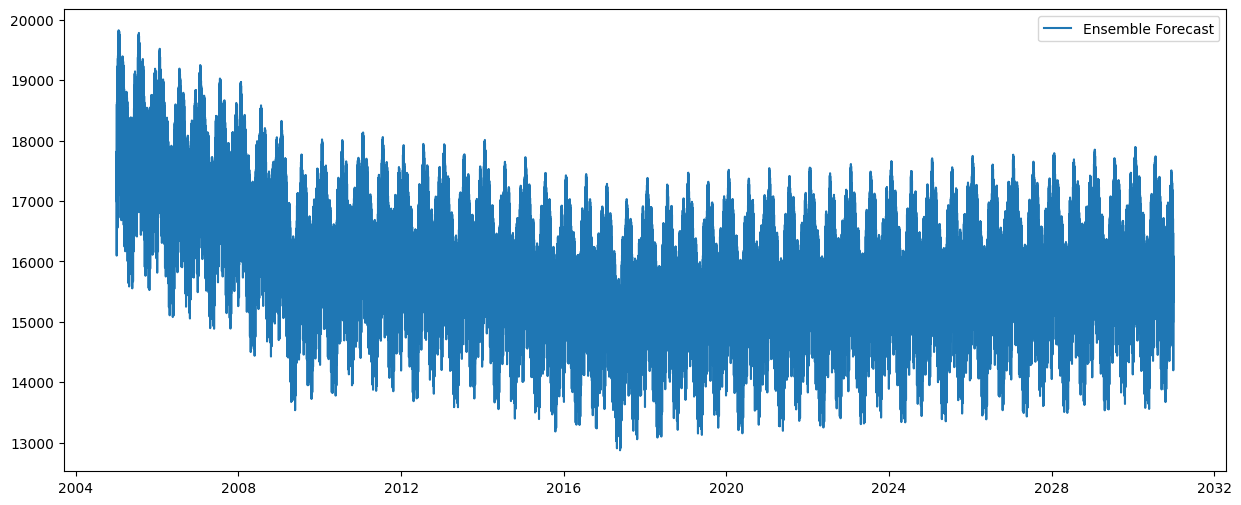

In [443]:


import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Ensemble Forecast')
#plt.plot(df['ds'], df['y'], label='Actual Data')
plt.legend()
#plt.title('Ensemble Forecast vs Actual Data')
plt.show()

# If you have a validation set, you can compute the error metrics to evaluate the ensemble forecast's performance.


In [444]:


# Assuming "df" is your DataFrame containing datetime column and the values to analyze

# Assuming your DataFrame has a "datetime" column (replace with the actual column name)
#forecast['datetime'] = pd.to_datetime(df['datetime'])

# Extract year and month from the datetime column
future_df['year'] = future_df['ds'].dt.year
future_df['month'] = future_df['ds'].dt.month
future_df['day'] = future_df['ds'].dt.day

# Group the data by year and month, and select the highest value for each month
result = future_df.groupby(['year', 'month'])['yhat'].max().reset_index()

#print(result)


C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\732484778.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df['year'] = future_df['ds'].dt.year
C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\732484778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df['month'] = future_df['ds'].dt.month
C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\732484778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [445]:
future_df

,ds,yhat,year,month,day
0,2005-01-01 00:00:00,17018.432004,2005,1,1
1,2005-01-01 01:00:00,16757.710210,2005,1,1
2,2005-01-01 02:00:00,16579.850308,2005,1,1
3,2005-01-01 03:00:00,16477.892631,2005,1,1
4,2005-01-01 04:00:00,16464.635402,2005,1,1
...,...,...,...,...,...
227851,2030-12-29 19:00:00,16090.039448,2030,12,29
227852,2030-12-29 20:00:00,16088.018374,2030,12,29
227853,2030-12-29 21:00:00,15936.734396,2030,12,29
227854,2030-12-29 22:00:00,15658.093801,2030,12,29


In [446]:

yearly_demand = future_df.groupby('year')['yhat'].sum()

# Print the total demand for each year
for year, total_demand in yearly_demand.items():
    print(f"Total demand for the year {year}: {total_demand}")


Total demand for the year 2005: 156605262.69245875
Total demand for the year 2006: 152672779.08993804
Total demand for the year 2007: 151016111.46544665
Total demand for the year 2008: 147636775.41274843
Total demand for the year 2009: 140746969.6323589
Total demand for the year 2010: 141690573.72586486
Total demand for the year 2011: 141832900.54428902
Total demand for the year 2012: 141243763.49646053
Total demand for the year 2013: 140166101.5034945
Total demand for the year 2014: 139224164.64801502
Total demand for the year 2015: 137178103.73302105
Total demand for the year 2016: 136683233.7690146
Total demand for the year 2017: 134054723.71172982
Total demand for the year 2018: 135626135.69766128
Total demand for the year 2019: 136101927.13697928
Total demand for the year 2020: 136812784.2994353
Total demand for the year 2021: 136776833.14964342
Total demand for the year 2022: 137105686.8017628
Total demand for the year 2023: 137441947.1656481
Total demand for the year 2024: 13816

In [447]:
yearly_demand.to_csv("yearly_demand_Prophet.csv")

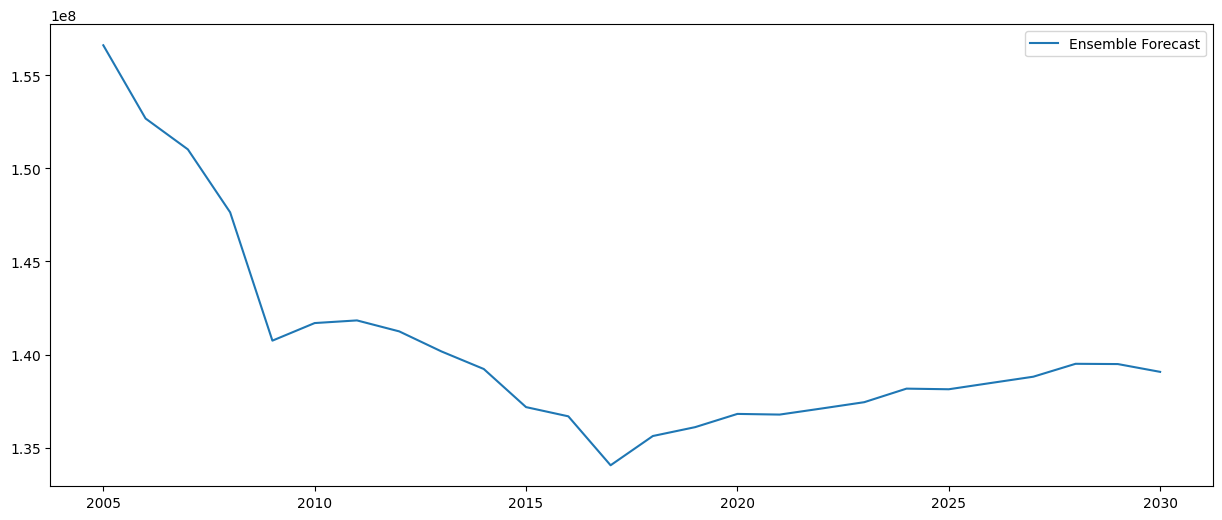

In [448]:

plt.figure(figsize=(15, 6))
plt.plot(yearly_demand, label='Ensemble Forecast')
#plt.plot(df['ds'], df['y'], label='Actual Data')
plt.legend()
#plt.title('Ensemble Forecast vs Actual Data')
plt.show()

In [450]:

# Extract the month from the datetime column and map it to seasons
season_map = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Autumn',
    10: 'Autumn', 11: 'Autumn', 12: 'Winter'
}

future_df['season'] = future_df['ds'].dt.month.map(season_map)




C:\Users\SENANU\AppData\Local\Temp\ipykernel_15244\963486235.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df['season'] = future_df['ds'].dt.month.map(season_map)


In [452]:


# Group the data by year and season, and find the highest value for each season within each year
seasonal_max_values = future_df.groupby(['year', 'season'])['yhat'].max().reset_index()

# Create a new DataFrame to store Winter and Summer max values
winter_summer_max_df = pd.DataFrame(columns=['year', 'winter_max', 'summer_max'])

# Filter and print out the highest winter and summer values for each year
for year in seasonal_max_values['year'].unique():
    winter_max = seasonal_max_values[(seasonal_max_values['year'] == year) & (seasonal_max_values['season'] == 'Winter')]['yhat'].values[0]
    summer_max = seasonal_max_values[(seasonal_max_values['year'] == year) & (seasonal_max_values['season'] == 'Summer')]['yhat'].values[0]
    print(f"Highest Winter Value for the year {year}: {winter_max}")
    print(f"Highest Summer Value for the year {year}: {summer_max}\n")

    df_to_append = pd.DataFrame({'year': [year], 'winter_max': [winter_max], 'summer_max': [summer_max]})
    winter_summer_max_df = pd.concat([winter_summer_max_df, df_to_append], ignore_index=True)


winter_summer_max_df.to_csv("winter_summer_max_df_Prophet.csv")


Highest Winter Value for the year 2005: 19827.475850538507
Highest Summer Value for the year 2005: 19783.653630121138

Highest Winter Value for the year 2006: 19521.163951680173
Highest Summer Value for the year 2006: 19192.681486582624

Highest Winter Value for the year 2007: 19251.793761233304
Highest Summer Value for the year 2007: 19028.585628618264

Highest Winter Value for the year 2008: 18972.105092513037
Highest Summer Value for the year 2008: 18584.263936668394

Highest Winter Value for the year 2009: 18326.74137748575
Highest Summer Value for the year 2009: 17770.96814772912

Highest Winter Value for the year 2010: 18020.384020333004
Highest Summer Value for the year 2010: 18009.959107994408

Highest Winter Value for the year 2011: 18135.360247035864
Highest Summer Value for the year 2011: 18059.65489744361

Highest Winter Value for the year 2012: 17925.93860865985
Highest Summer Value for the year 2012: 17946.05333169622

Highest Winter Value for the year 2013: 17939.0782564

In [453]:
data2 = data[["ds","Ontario Demand"]]

In [454]:
data.set_index("ds", inplace=True)

In [455]:
df = data

In [456]:
"""plt.plot(data1["ds"], data1["mean"], label='Prophet Time Series')

# Plotting the second time series
plt.plot(data2["ds"], data2["Ontario Demand"], label='Original Time Series')

# Set the labels and title for the plot
plt.xlabel('Hour')
plt.ylabel('MW')
plt.title('Prophet vs Ontario Demand')
#plt.axvline(x=train_set["ds"].iloc[-1], linestyle="--", color="black")
# Display the legend

year_locator = YearLocator()
plt.gca().xaxis.set_major_locator(year_locator)

# Format x-axis labels to show only years
date_formatter = DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(date_formatter)

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()


plt.legend()

# Display the plot
plt.show()"""

'plt.plot(data1["ds"], data1["mean"], label=\'Prophet Time Series\')\n\n# Plotting the second time series\nplt.plot(data2["ds"], data2["Ontario Demand"], label=\'Original Time Series\')\n\n# Set the labels and title for the plot\nplt.xlabel(\'Hour\')\nplt.ylabel(\'MW\')\nplt.title(\'Prophet vs Ontario Demand\')\n#plt.axvline(x=train_set["ds"].iloc[-1], linestyle="--", color="black")\n# Display the legend\n\nyear_locator = YearLocator()\nplt.gca().xaxis.set_major_locator(year_locator)\n\n# Format x-axis labels to show only years\ndate_formatter = DateFormatter(\'%Y\')\nplt.gca().xaxis.set_major_formatter(date_formatter)\n\n# Rotate x-axis labels for better readability\nplt.gcf().autofmt_xdate()\n\n\nplt.legend()\n\n# Display the plot\nplt.show()'

### Future Demand

In [457]:
"""import pandas as pd
from fbprophet import Prophet

# Sample data preparation (replace this with your actual data)
# df should have columns 'ds' and 'y'
df = pd.read_csv('your_data.csv')

# Splitting the data into training and validation (optional)
train = df.iloc[:-24*30]  # Assuming you want to leave out the last month for validation
validation = df.iloc[-24*30:]

# Train three separate Prophet models
model1 = Prophet()
model1.fit(train)

model2 = Prophet()
model2.fit(train)

model3 = Prophet()
model3.fit(train)

# Forecast into the future with each model
future = model1.make_future_dataframe(periods=24*365*7, freq='H')  # Forecasting 7 years into the future at hourly resolution

forecast1 = model1.predict(future)
forecast2 = model2.predict(future)
forecast3 = model3.predict(future)

# Ensemble the forecasts by averaging
ensemble_forecast = forecast1[['ds']].copy()
ensemble_forecast['yhat'] = (forecast1['yhat'] + forecast2['yhat'] + forecast3['yhat']) / 3

# Plotting the ensemble forecast (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(ensemble_forecast['ds'], ensemble_forecast['yhat'], label='Ensemble Forecast')
plt.plot(df['ds'], df['y'], label='Actual Data')
plt.legend()
plt.title('Ensemble Forecast vs Actual Data')
plt.show()"""

# If you have a validation set, you can compute the error metrics to evaluate the ensemble forecast's performance.


"import pandas as pd\nfrom fbprophet import Prophet\n\n# Sample data preparation (replace this with your actual data)\n# df should have columns 'ds' and 'y'\ndf = pd.read_csv('your_data.csv')\n\n# Splitting the data into training and validation (optional)\ntrain = df.iloc[:-24*30]  # Assuming you want to leave out the last month for validation\nvalidation = df.iloc[-24*30:]\n\n# Train three separate Prophet models\nmodel1 = Prophet()\nmodel1.fit(train)\n\nmodel2 = Prophet()\nmodel2.fit(train)\n\nmodel3 = Prophet()\nmodel3.fit(train)\n\n# Forecast into the future with each model\nfuture = model1.make_future_dataframe(periods=24*365*7, freq='H')  # Forecasting 7 years into the future at hourly resolution\n\nforecast1 = model1.predict(future)\nforecast2 = model2.predict(future)\nforecast3 = model3.predict(future)\n\n# Ensemble the forecasts by averaging\nensemble_forecast = forecast1[['ds']].copy()\nensemble_forecast['yhat'] = (forecast1['yhat'] + forecast2['yhat'] + forecast3['yhat']) / 